In [4]:
from curl_sac import RadSacAgent

import numpy as np
import torch
import argparse
import os
import math
import gym
import sys
import random
import time
import json
import dmc2gym
import copy
import retro
from pathlib import Path
import weightwatcher as ww

import utils
from logger import Logger
from video import VideoRecorder

from curl_sac import RadSacAgent
from torchvision import transforms
import data_augs as rad

In [5]:
def parse_args(file_path):
    args = json.load(open(os.path.join(file_path, 'args.json')))
    return args

def make_agent(obs_shape, action_shape, args, device):
    if args.agent == 'rad_sac':
        return RadSacAgent(
            obs_shape=obs_shape,
            action_shape=action_shape,
            device=device,
            hidden_dim=args.hidden_dim,
            discount=args.discount,
            init_temperature=args.init_temperature,
            alpha_lr=args.alpha_lr,
            alpha_beta=args.alpha_beta,
            actor_lr=args.actor_lr,
            actor_beta=args.actor_beta,
            actor_log_std_min=args.actor_log_std_min,
            actor_log_std_max=args.actor_log_std_max,
            actor_update_freq=args.actor_update_freq,
            critic_lr=args.critic_lr,
            critic_beta=args.critic_beta,
            critic_tau=args.critic_tau,
            critic_target_update_freq=args.critic_target_update_freq,
            encoder_type=args.encoder_type,
            encoder_feature_dim=args.encoder_feature_dim,
            encoder_lr=args.encoder_lr,
            encoder_tau=args.encoder_tau,
            num_layers=args.num_layers,
            num_filters=args.num_filters,
            log_interval=args.log_interval,
            detach_encoder=args.detach_encoder,
            latent_dim=args.latent_dim,
            data_augs=args.data_augs
        )
    else:
        assert 'agent is not supported: %s' % args.agent

In [6]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [50]:
def plot_ww(file_path):
    
    args = parse_args(file_path)
    args = dotdict(args)
    if args['seed'] == -1: 
        args.__dict__["seed"] = np.random.randint(1,1000000)
    utils.set_seed_everywhere(args['seed'])

    pre_transform_image_size = args['pre_transform_image_size'] if 'crop' in args['data_augs'] else args['image_size']
    pre_image_size = args['pre_transform_image_size'] # record the pre transform image size for translation

    env = dmc2gym.make(
        domain_name=args.domain_name,
        task_name=args.task_name,
        seed=args.seed,
        visualize_reward=False,
        from_pixels=(args.encoder_type == 'pixel'),
        height=pre_transform_image_size,
        width=pre_transform_image_size,
        frame_skip=args.action_repeat
    )

    env.seed(args['seed'])

    # stack several consecutive frames together
    if args.encoder_type == 'pixel':
        env = utils.FrameStack(env, k=args.frame_stack)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    action_shape = env.action_space.shape

    if args.encoder_type == 'pixel':
        obs_shape = (3*args.frame_stack, args.image_size, args.image_size)
        pre_aug_obs_shape = (3*args.frame_stack,pre_transform_image_size,pre_transform_image_size)
    else:
        obs_shape = env.observation_space.shape
        pre_aug_obs_shape = obs_shape

    replay_buffer = utils.ReplayBuffer(
        obs_shape=pre_aug_obs_shape,
        action_shape=action_shape,
        capacity=args.replay_buffer_capacity,
        batch_size=args.batch_size,
        device=device,
        image_size=args.image_size,
        pre_image_size=pre_image_size,
    )

    agent = make_agent(
        obs_shape=obs_shape,
        action_shape=action_shape,
        args=args,
        device=device
    )
    
    agent.load(os.path.join(file_path, 'model'), 190000)
               # from utils import prepare_model
    domain_task_aug_hp = '-'.join(file_path.split('/')[1].split('-')[:3]) + f'_min{args.min_cut}_max{args.max_cut}'
    
    # Check whether the specified path exists or not
    logdir = os.path.join('outputs', domain_task_aug_hp)

    if not os.path.exists(logdir):
        os.makedirs(logdir)
    else:
        return

#     DEFAULT_PARAMS = {'glorot_fix': False, 'normalize':False, 'conv2d_norm':True, 'randomize': True, 
#                       'savedir':logdir, 'savefig':True, 'rescale':True, 'plot':False,
#                       'deltaEs':False, 'intra':False, 'channels':None, 'conv2d_fft':False, 
#                       'ww2x':False, 'vectors':False, 'smooth':None, 'stacked':False, 
#                       'svd_method':FULL_SVD,  'fix_fingers':None}
    
    watcher = ww.WeightWatcher(model=agent.actor)
    details = watcher.analyze(plot=True, randomize=True, savefig=logdir)
    details.to_csv(os.path.join(logdir, "esd_plot.csv"))
#     # check csv to get which layers to input into the analyze function's arg in the next lines
#     esd_layer_ = watcher.get_esd()

#     summary = watcher.get_summary(details)
#     # layers_6 = [127,142,90,71,48,46] # rank and choose from esd_plot.csv
#     # details = watcher.analyze(plot=True, randomize=True, savefig="esd_plot_figure", layers=layers_6)
#     details = watcher.analyze(randomize=True, plot=True)

INFO:weightwatcher:

python      version 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
numpy       version 1.19.2
tensforflow version 2.7.0
keras       version 2.7.0
INFO:weightwatcher:Saving all images to outputs/finger-spin-no_aug_min10_max30
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'outputs/reacher-easy-no_aug_min10_max30', 'savefig': 'outputs/reacher-easy-no_aug_min10_max30', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all images to outputs/reacher-easy-no_aug_min10_max30


Assuming nested distributions


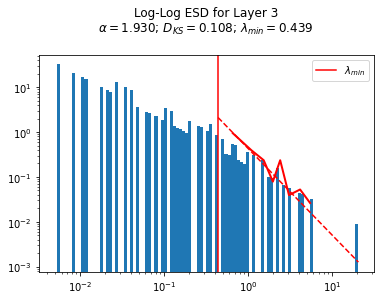

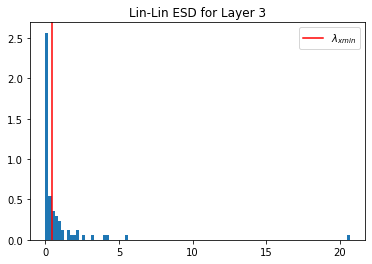

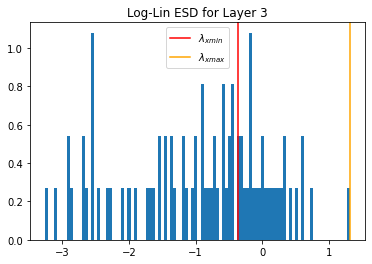

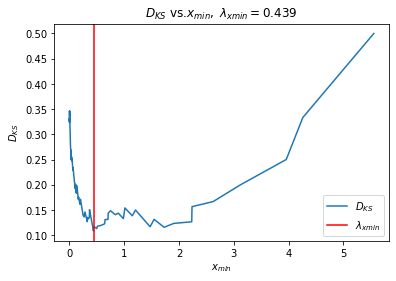

<Figure size 432x288 with 0 Axes>

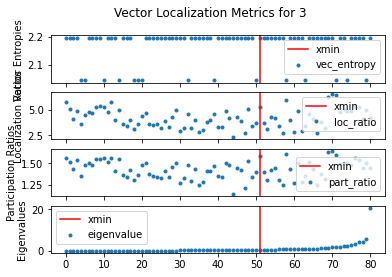

<Figure size 432x288 with 0 Axes>

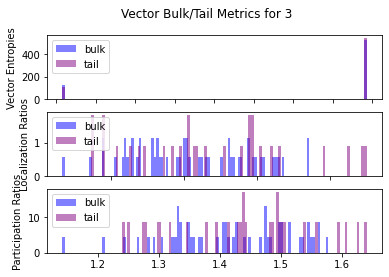

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


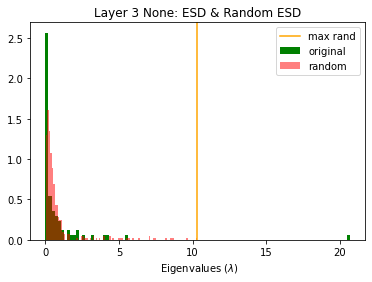

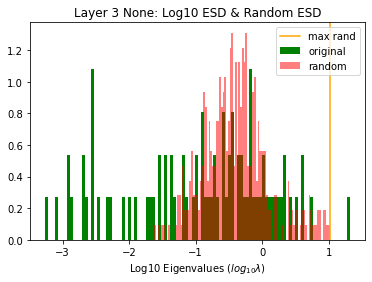

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


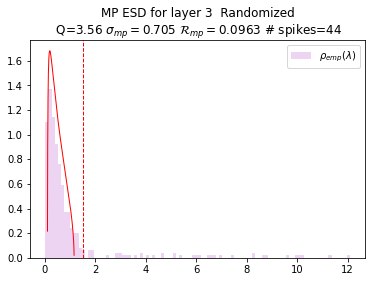

Assuming nested distributions


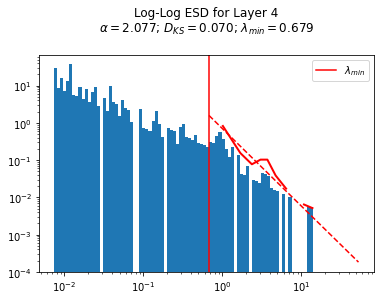

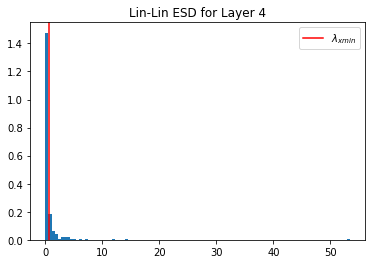

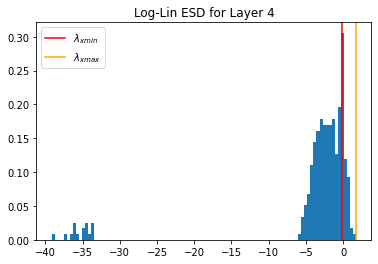

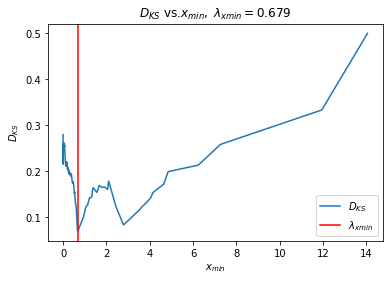

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/numpy/lib/histograms.py:904: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<Figure size 432x288 with 0 Axes>

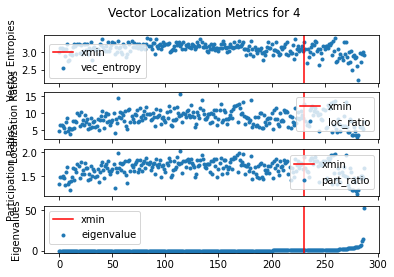

<Figure size 432x288 with 0 Axes>

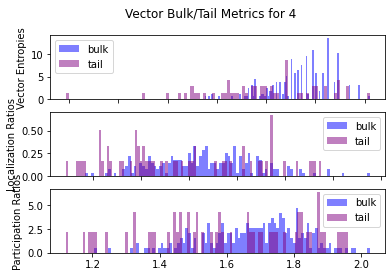

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


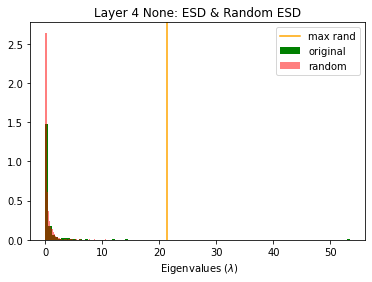

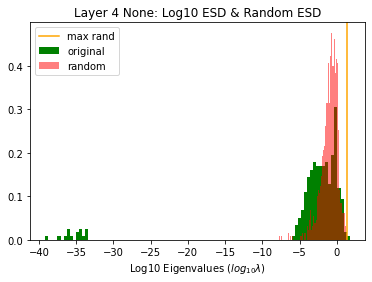

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


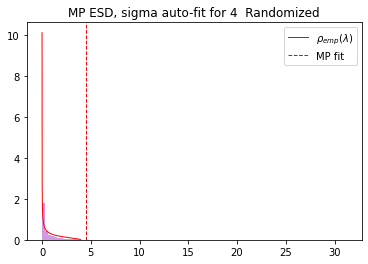

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


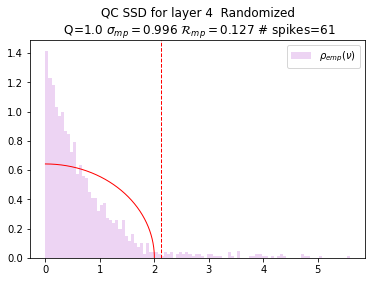

Assuming nested distributions


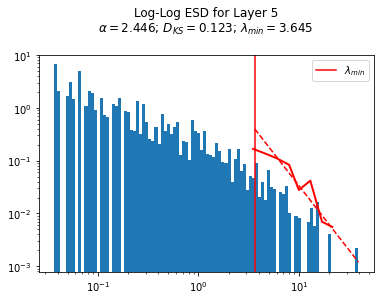

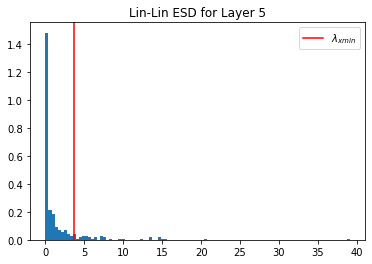

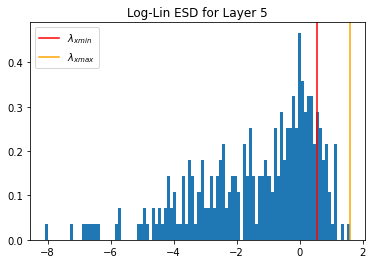

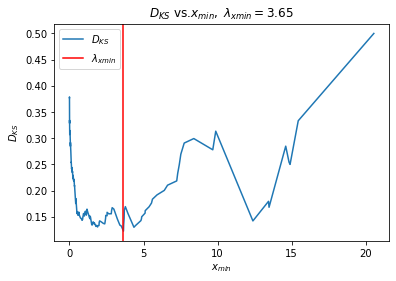

<Figure size 432x288 with 0 Axes>

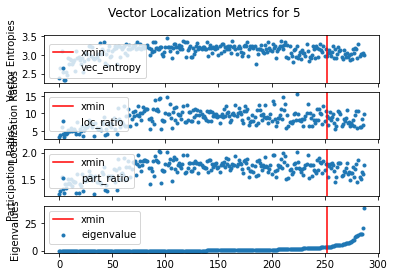

<Figure size 432x288 with 0 Axes>

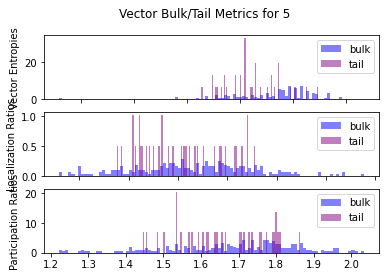

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


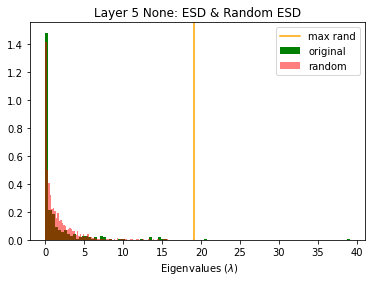

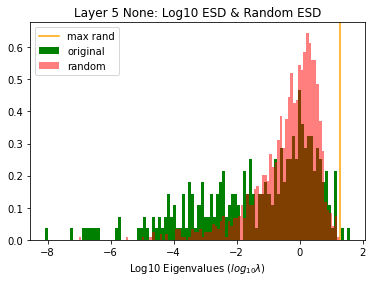

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


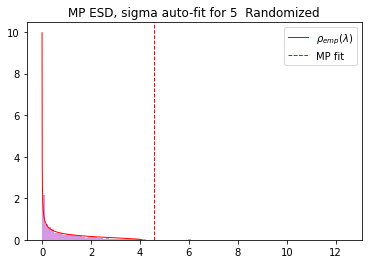

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


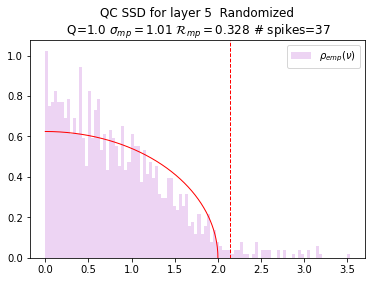

Assuming nested distributions


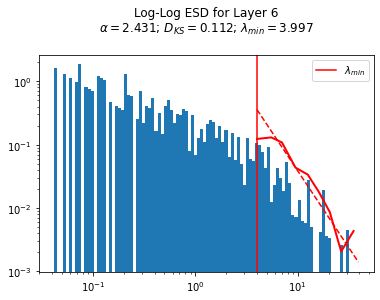

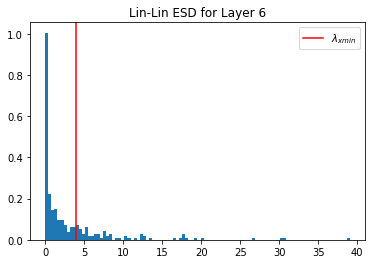

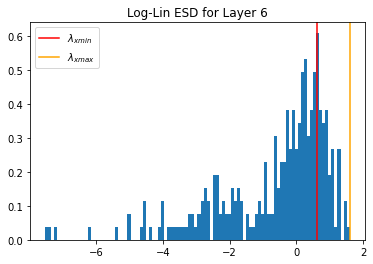

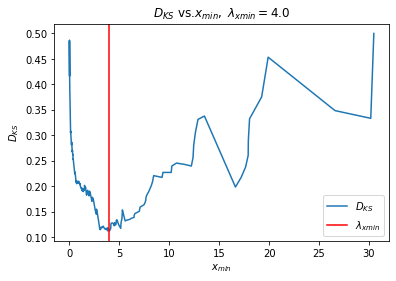

<Figure size 432x288 with 0 Axes>

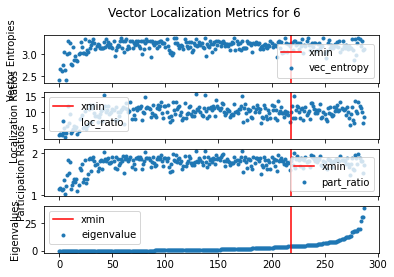

<Figure size 432x288 with 0 Axes>

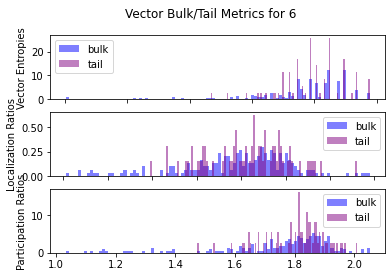

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


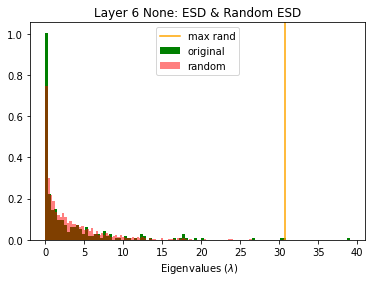

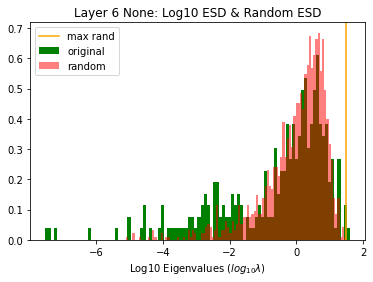

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


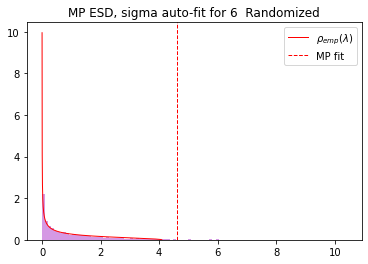

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


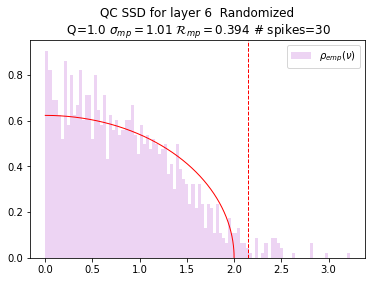

Assuming nested distributions


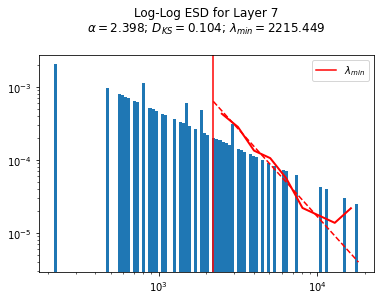

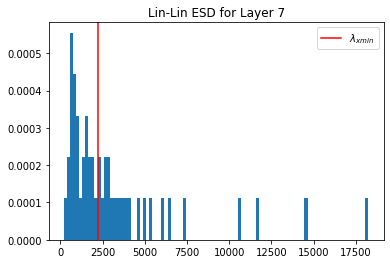

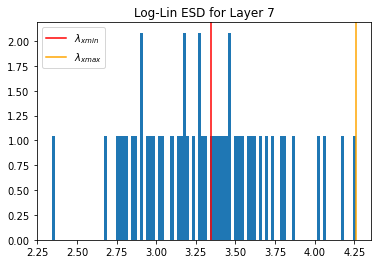

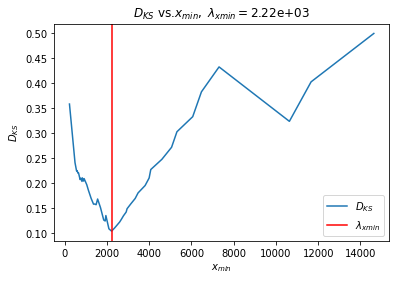

<Figure size 432x288 with 0 Axes>

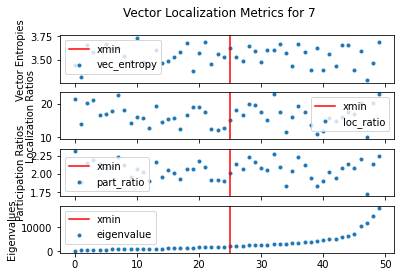

<Figure size 432x288 with 0 Axes>

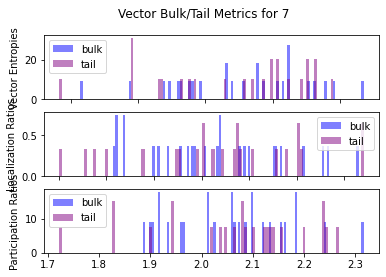

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


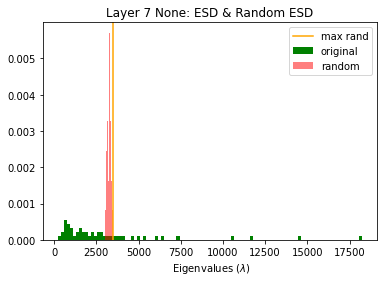

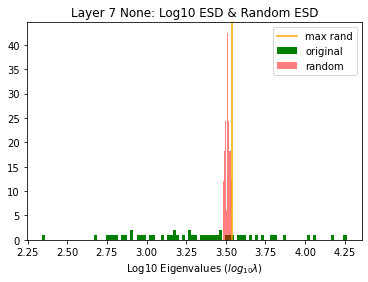

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


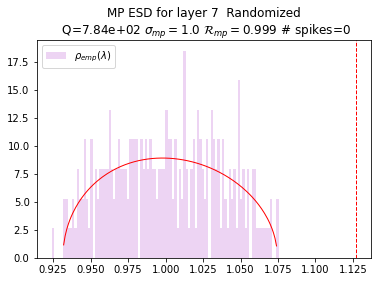

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


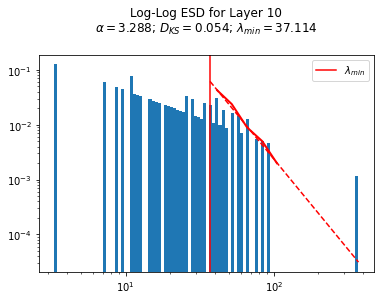

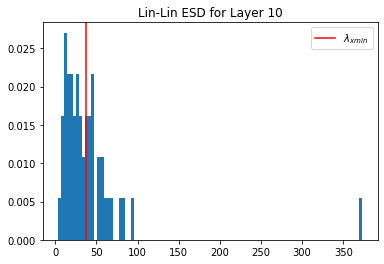

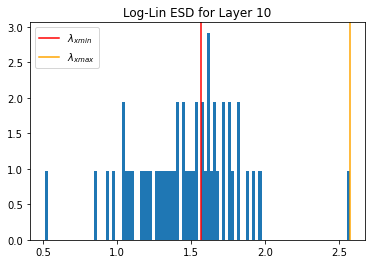

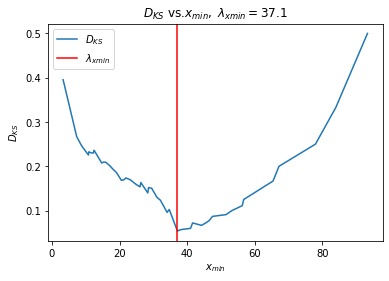

<Figure size 432x288 with 0 Axes>

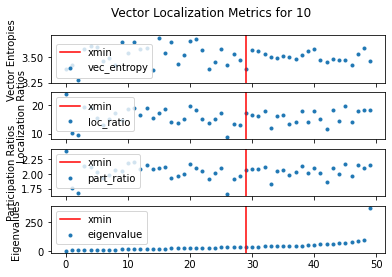

<Figure size 432x288 with 0 Axes>

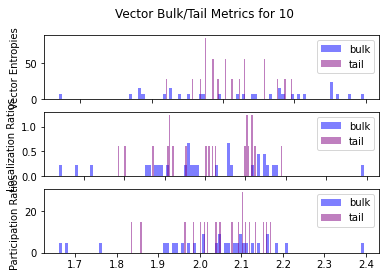

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


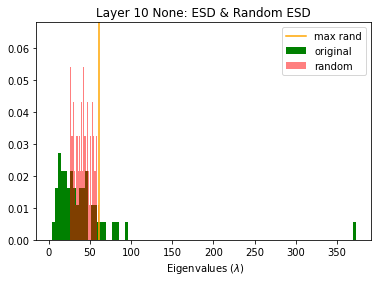

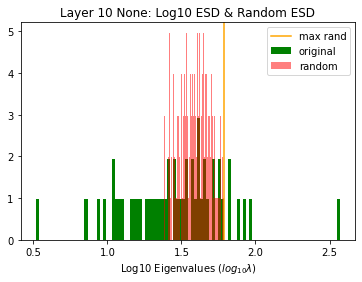

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


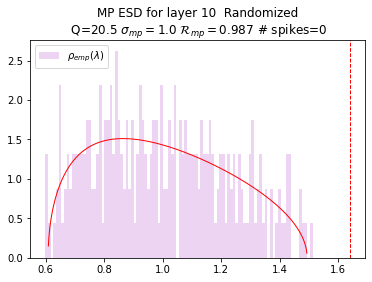

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


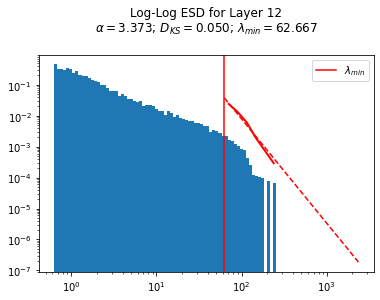

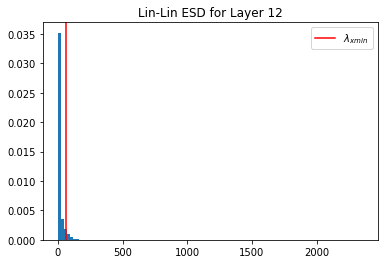

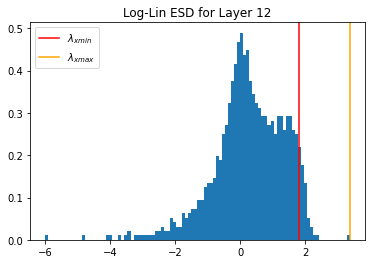

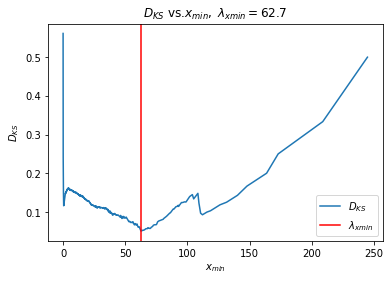

<Figure size 432x288 with 0 Axes>

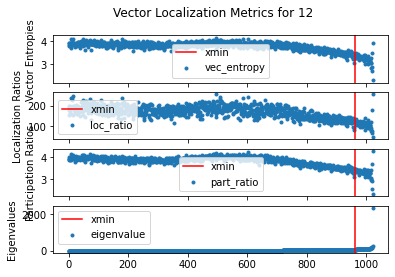

<Figure size 432x288 with 0 Axes>

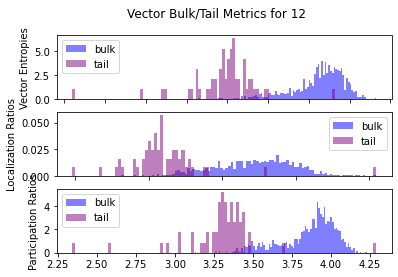

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


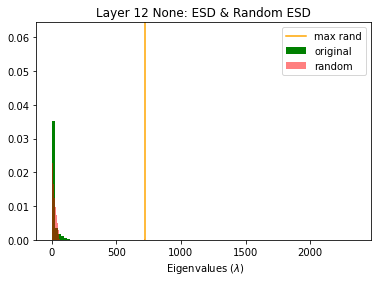

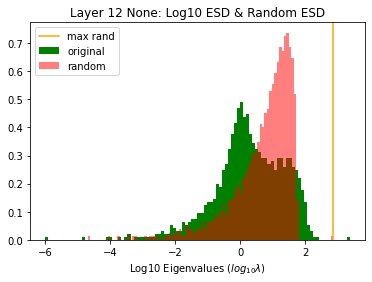

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


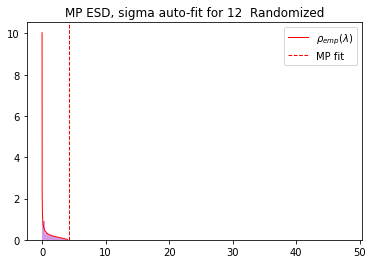

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


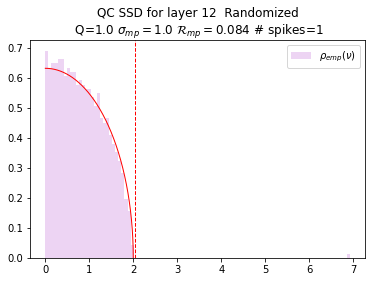

Assuming nested distributions


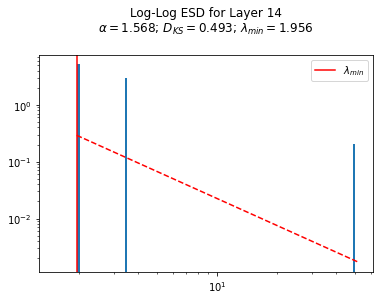

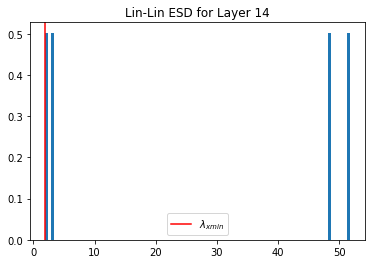

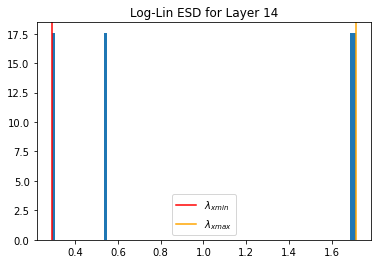

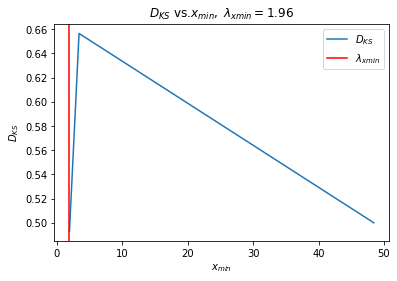

<Figure size 432x288 with 0 Axes>

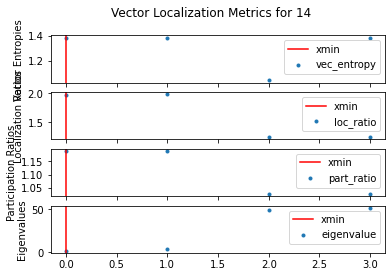

<Figure size 432x288 with 0 Axes>

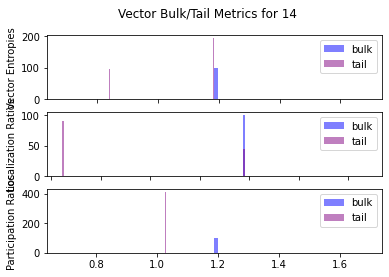

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


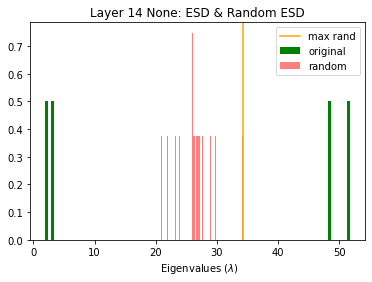

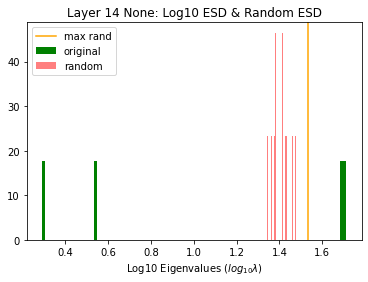

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


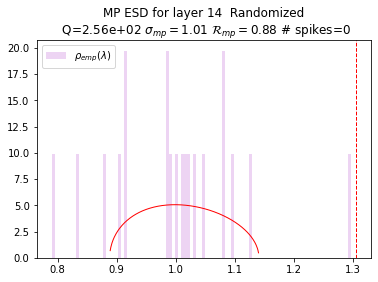

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)
INFO:weightwatcher:

python      version 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
numpy       version 1.19.2
tensforflow version 2.7.0
keras       version 2.7.0
INFO:weightwatcher:Saving all images to outputs/reacher-easy-no_aug_min10_max30
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'outputs/walker-walk-no_aug_min10_max30', 'savefig': 'outputs/walker-walk-no_aug_min10_max30', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwatcher:Saving all 

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


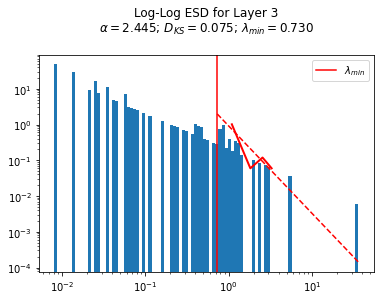

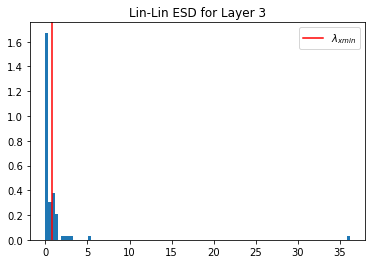

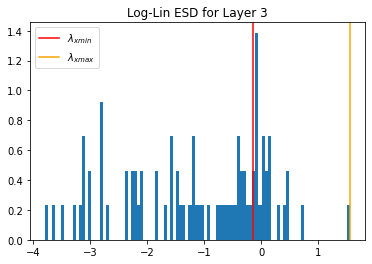

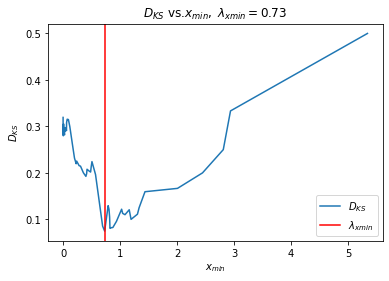

<Figure size 432x288 with 0 Axes>

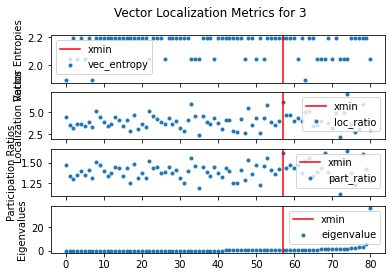

<Figure size 432x288 with 0 Axes>

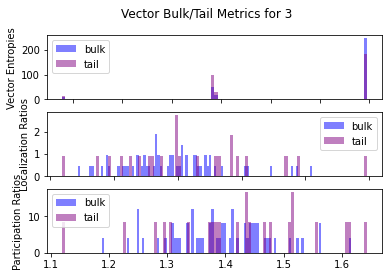

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


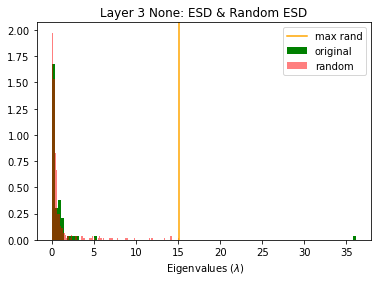

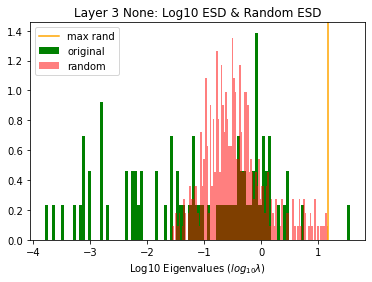

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


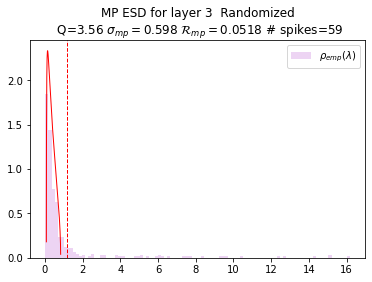

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


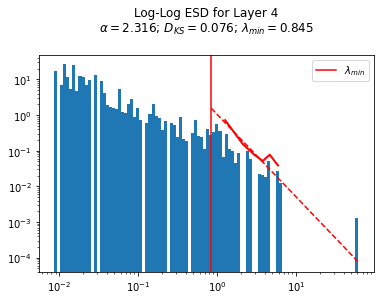

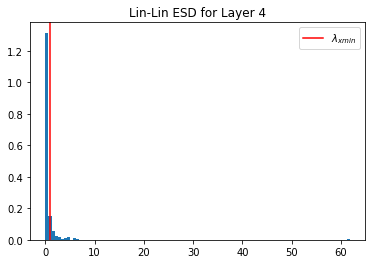

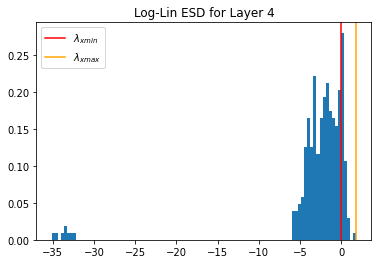

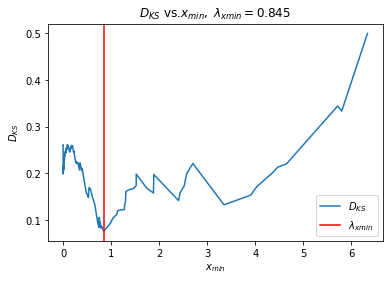

<Figure size 432x288 with 0 Axes>

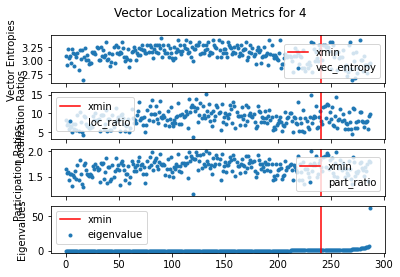

<Figure size 432x288 with 0 Axes>

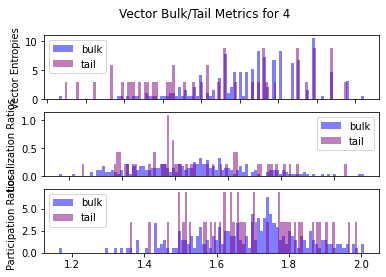

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


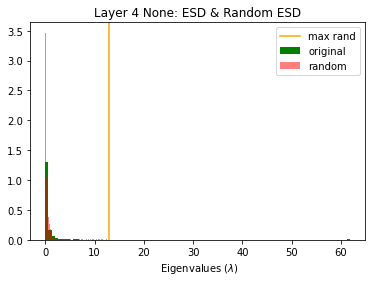

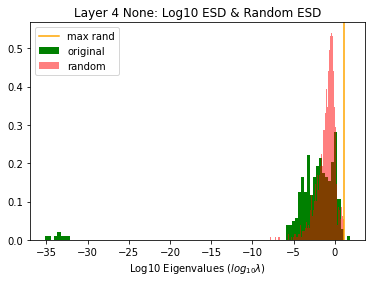

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


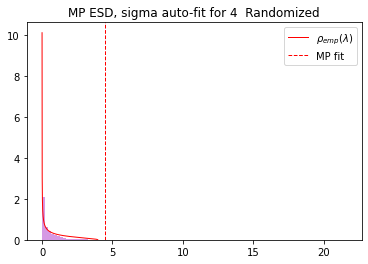

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


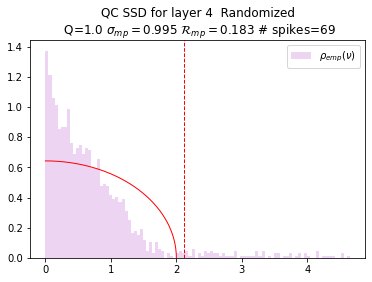

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(p * np.log(p)) / np.log(rank)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(p * np.log(p)) / np.log(rank)


Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


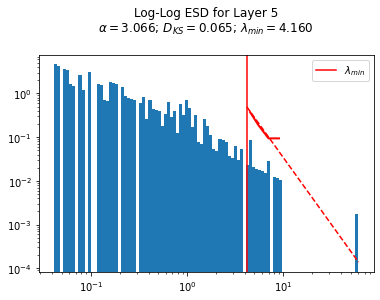

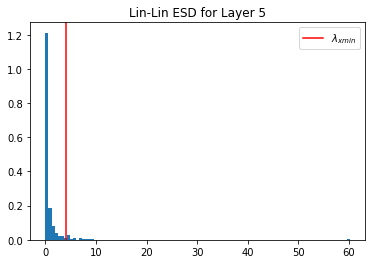

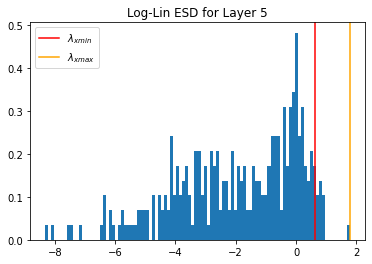

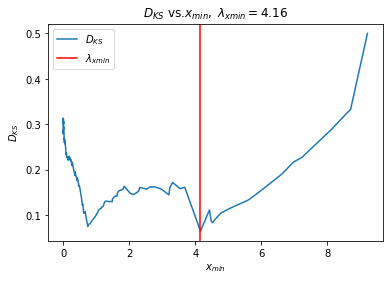

<Figure size 432x288 with 0 Axes>

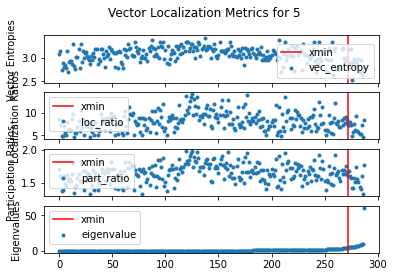

<Figure size 432x288 with 0 Axes>

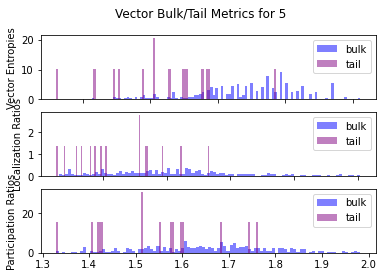

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


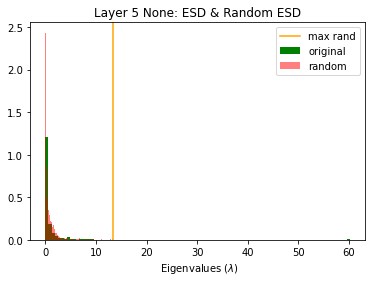

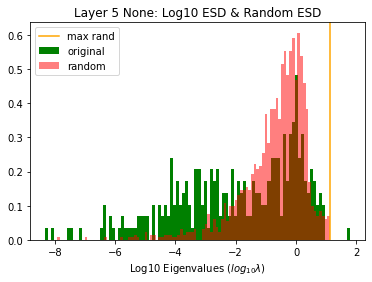

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


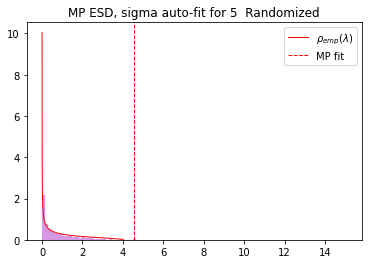

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


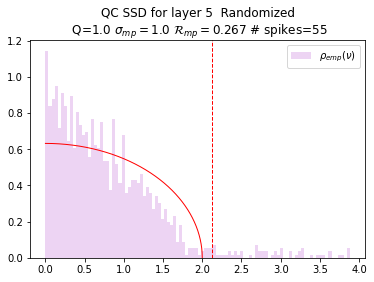

Assuming nested distributions


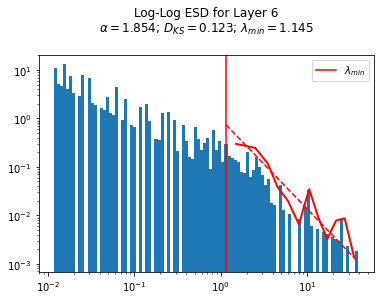

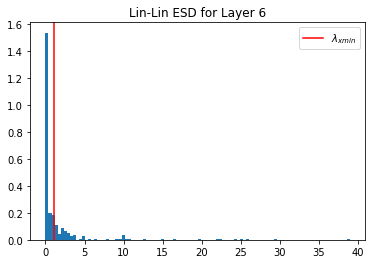

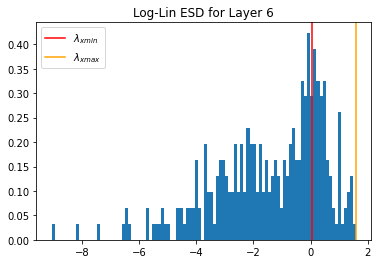

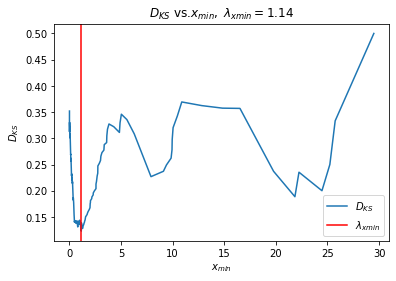

<Figure size 432x288 with 0 Axes>

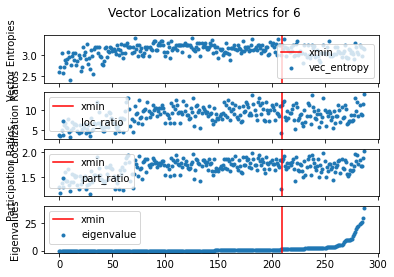

<Figure size 432x288 with 0 Axes>

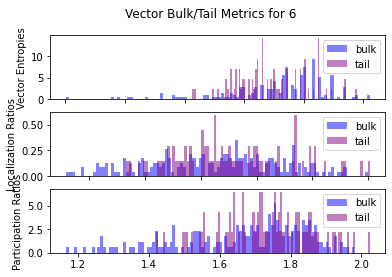

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


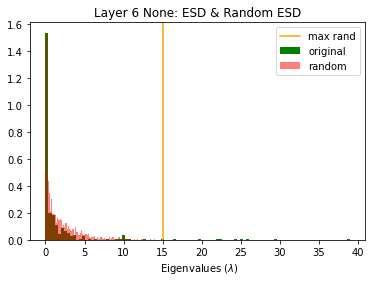

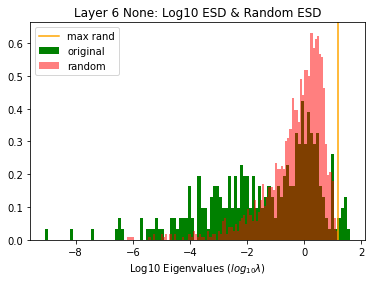

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


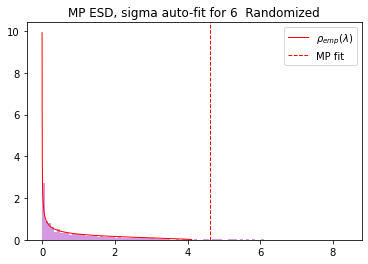

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


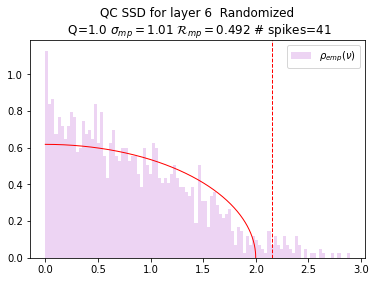

Assuming nested distributions


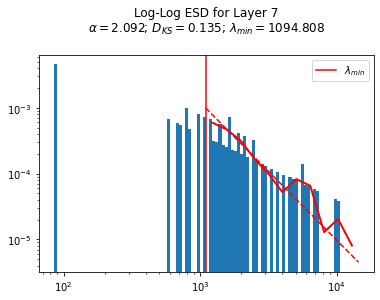

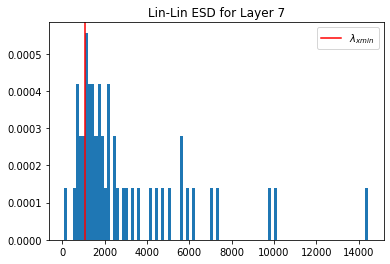

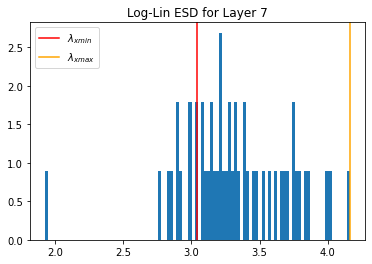

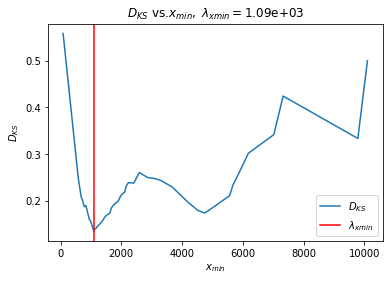

<Figure size 432x288 with 0 Axes>

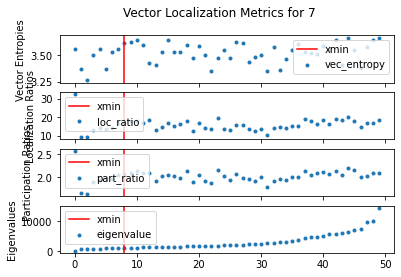

<Figure size 432x288 with 0 Axes>

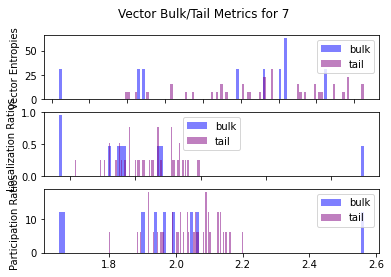

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


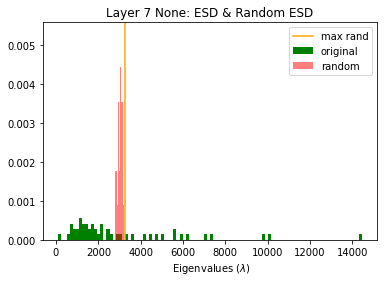

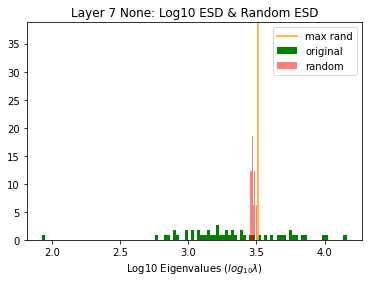

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


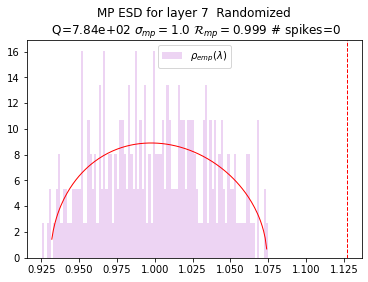

Assuming nested distributions


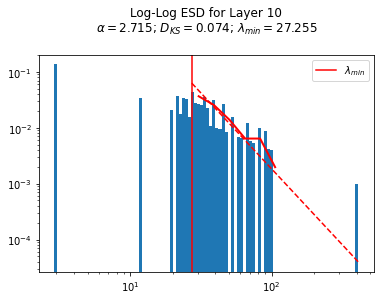

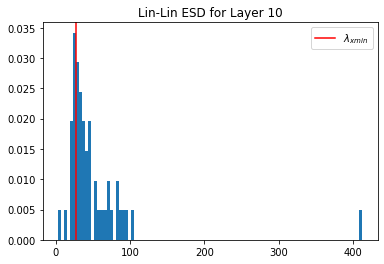

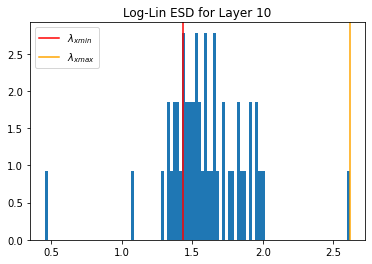

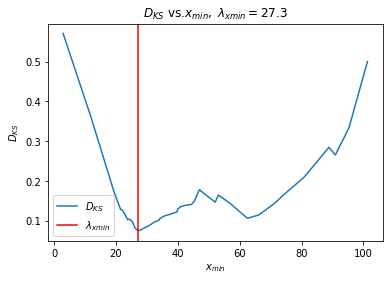

<Figure size 432x288 with 0 Axes>

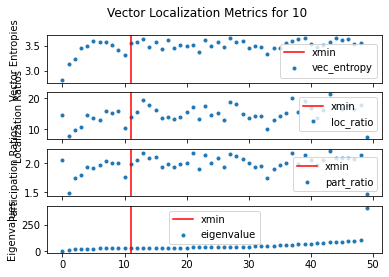

<Figure size 432x288 with 0 Axes>

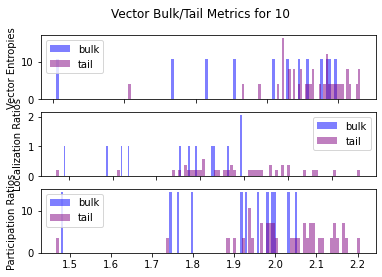

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


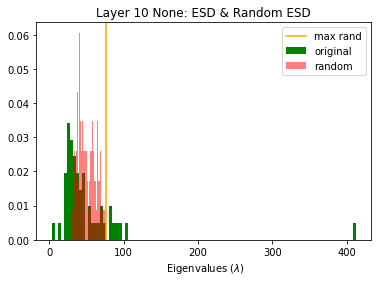

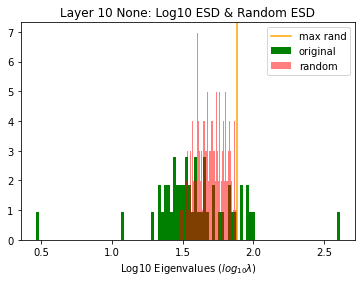

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


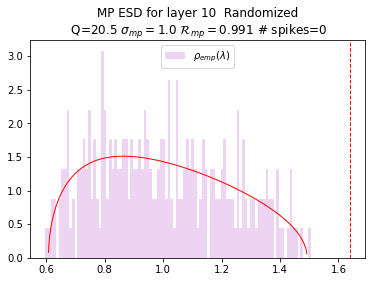

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


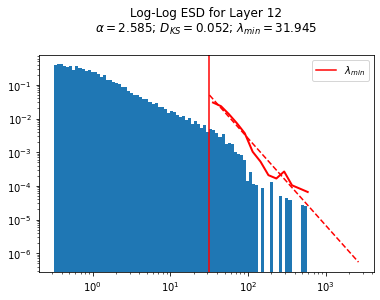

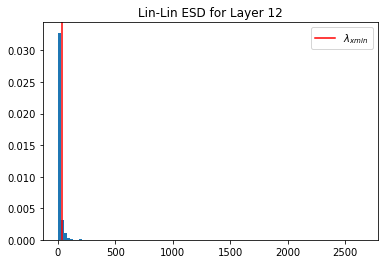

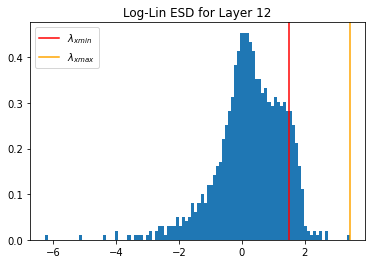

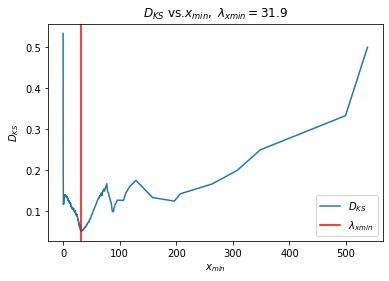

<Figure size 432x288 with 0 Axes>

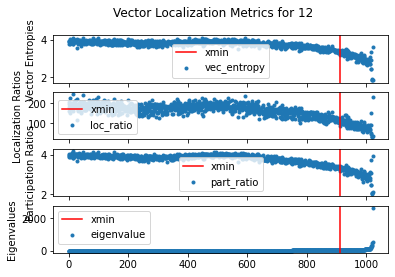

<Figure size 432x288 with 0 Axes>

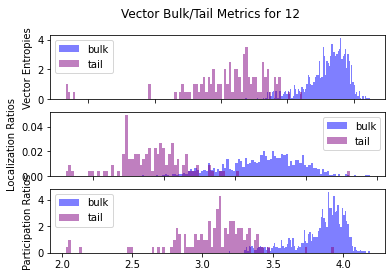

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


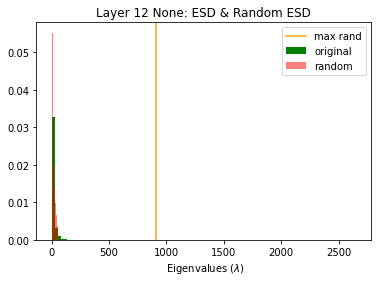

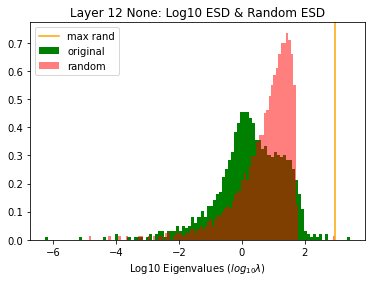

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


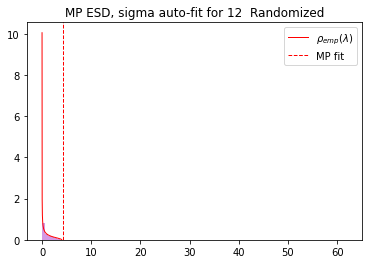

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


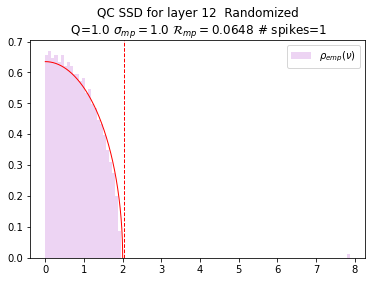

Assuming nested distributions


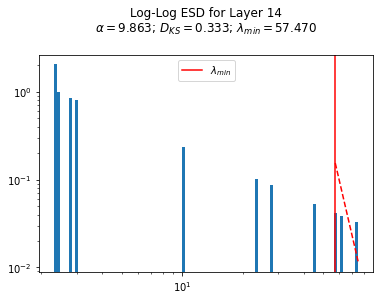

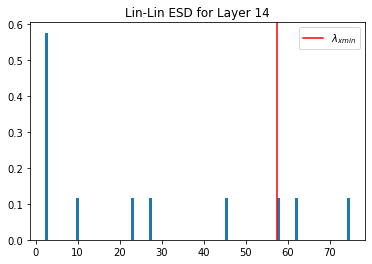

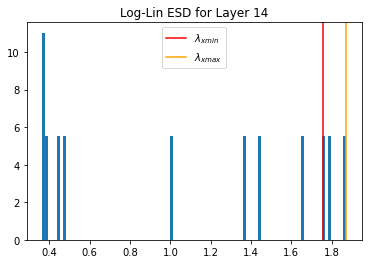

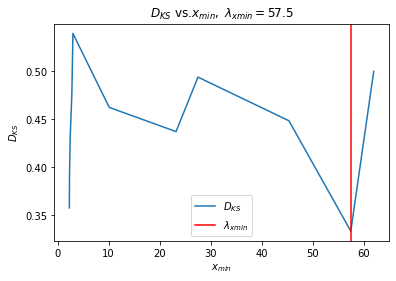

<Figure size 432x288 with 0 Axes>

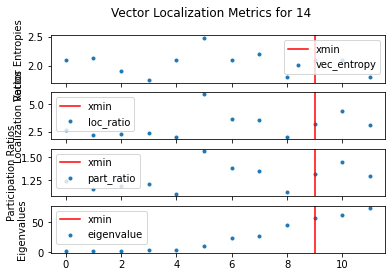

<Figure size 432x288 with 0 Axes>

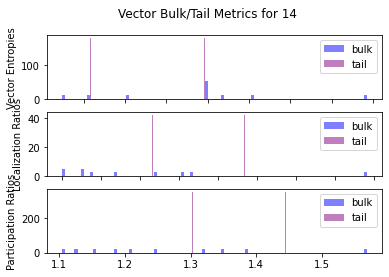

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


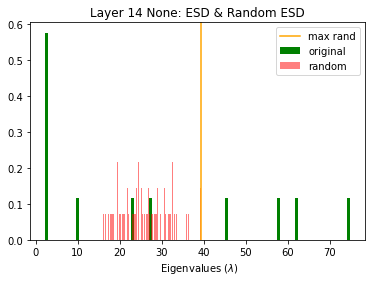

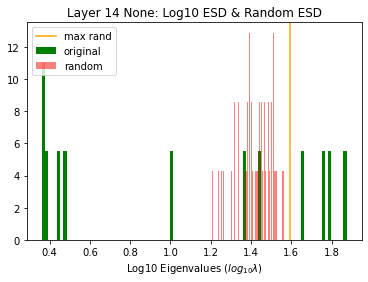

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


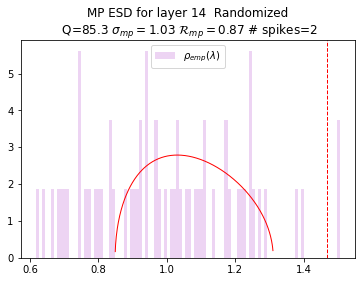

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)
INFO:weightwatcher:

python      version 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
numpy       version 1.19.2
tensforflow version 2.7.0
keras       version 2.7.0
INFO:weightwatcher:Saving all images to outputs/walker-walk-no_aug_min10_max30
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'outputs/walker-walk-rand_inv_cutout_min10_max30', 'savefig': 'outputs/walker-walk-rand_inv_cutout_min10_max30', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers': []}
INFO:weightwa

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


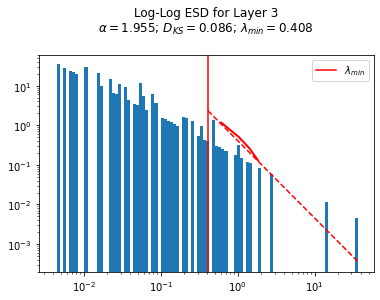

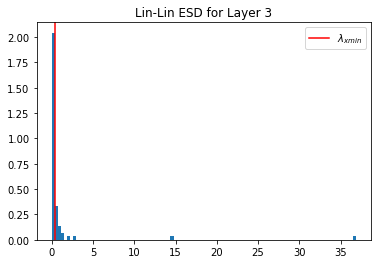

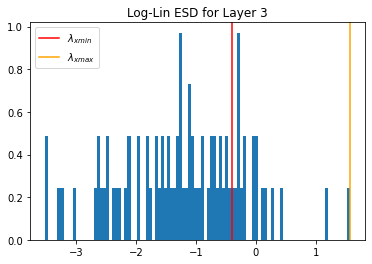

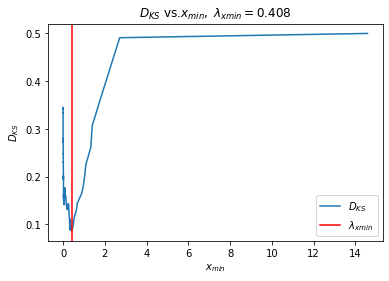

<Figure size 432x288 with 0 Axes>

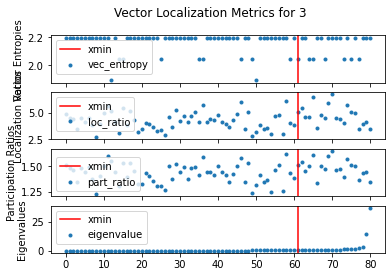

<Figure size 432x288 with 0 Axes>

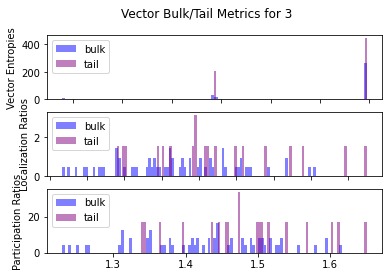

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


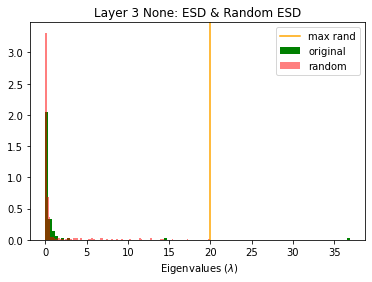

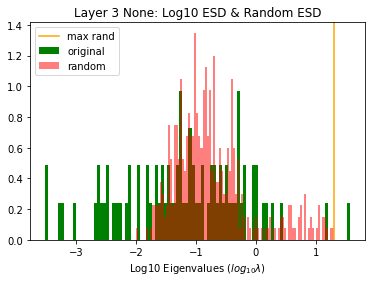

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


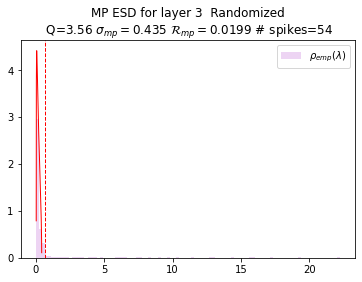

Assuming nested distributions


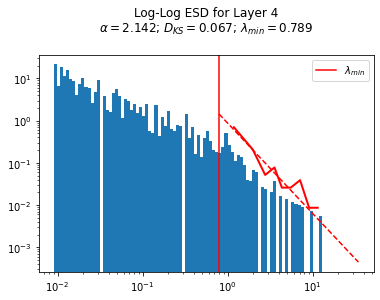

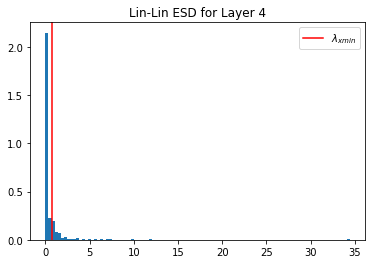

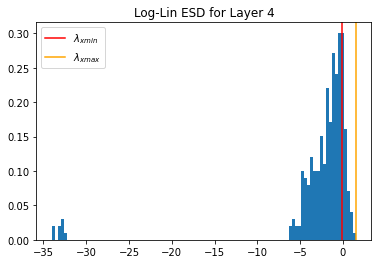

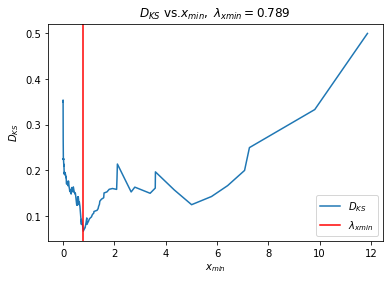

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/numpy/lib/histograms.py:904: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


<Figure size 432x288 with 0 Axes>

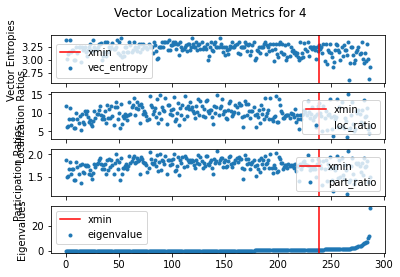

<Figure size 432x288 with 0 Axes>

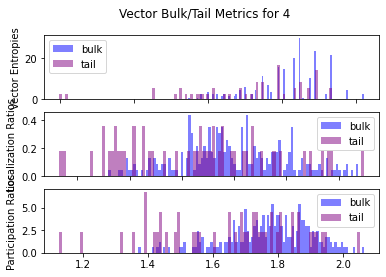

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


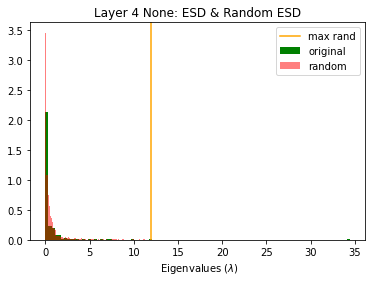

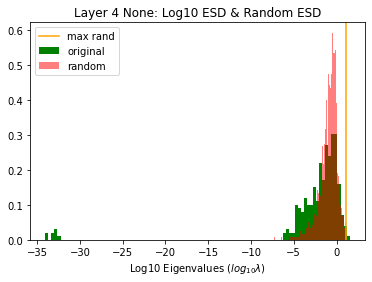

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


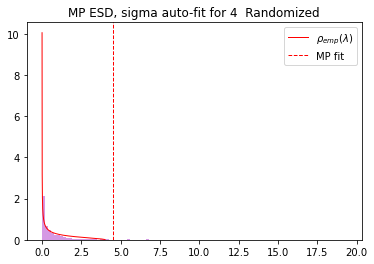

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


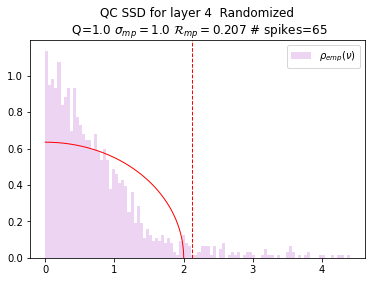

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(p * np.log(p)) / np.log(rank)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(p * np.log(p)) / np.log(rank)


Assuming nested distributions


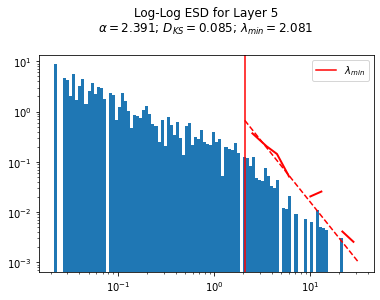

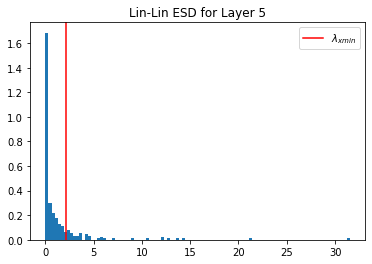

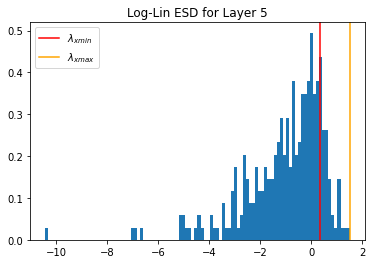

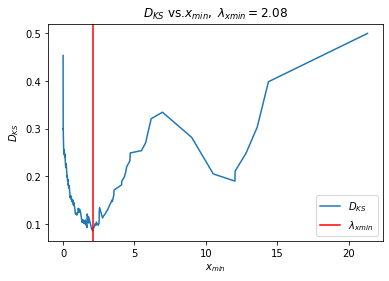

<Figure size 432x288 with 0 Axes>

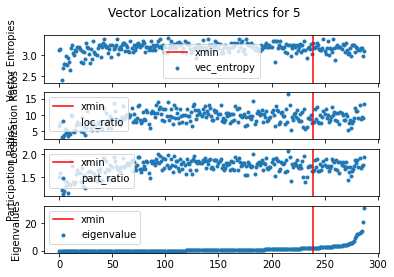

<Figure size 432x288 with 0 Axes>

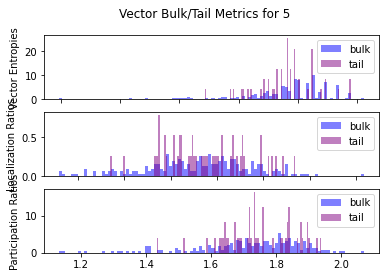

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


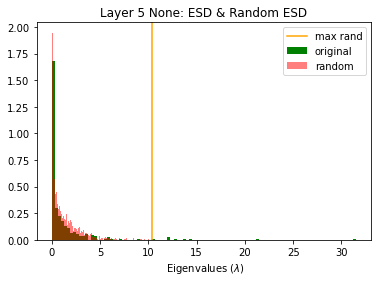

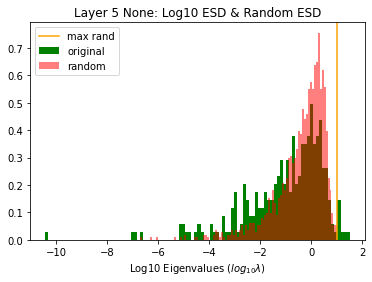

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


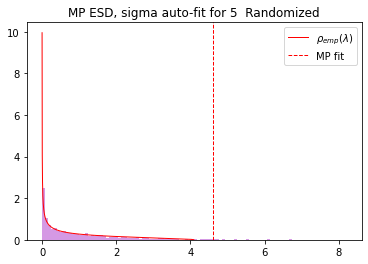

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


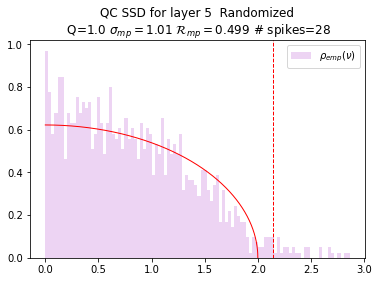

Assuming nested distributions


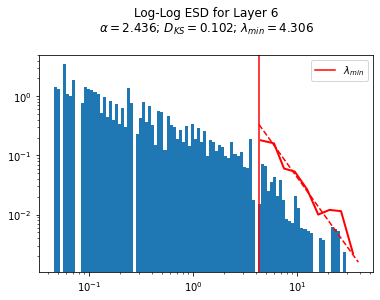

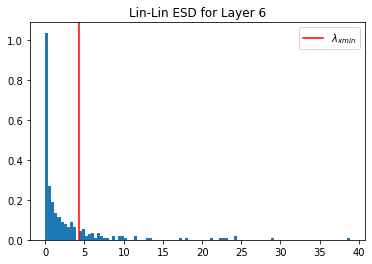

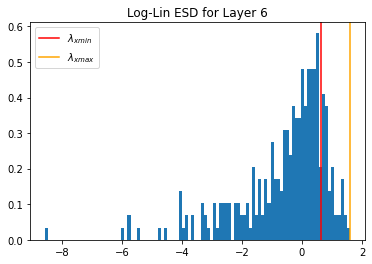

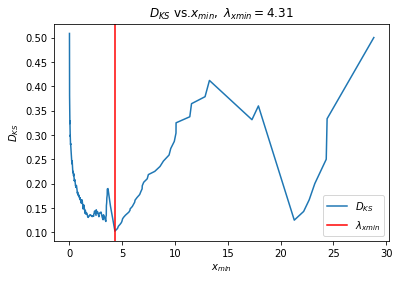

<Figure size 432x288 with 0 Axes>

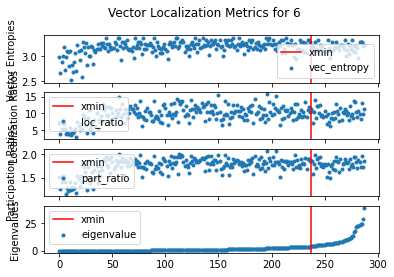

<Figure size 432x288 with 0 Axes>

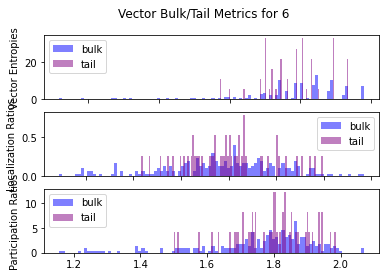

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


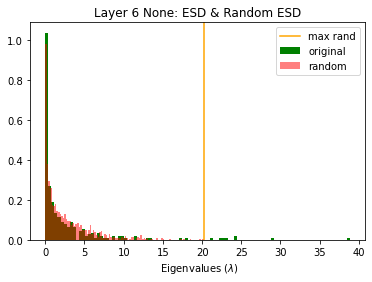

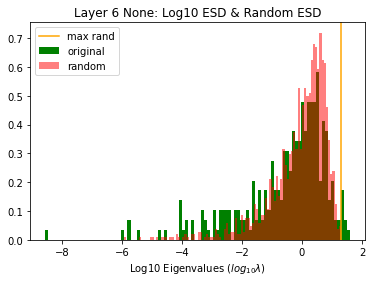

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


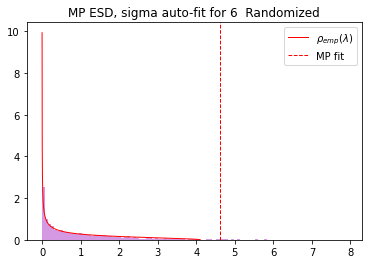

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


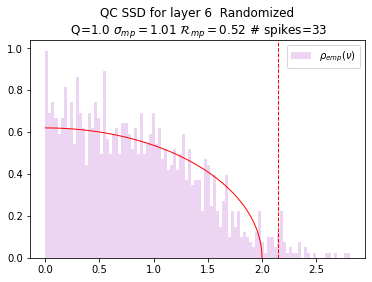

Assuming nested distributions


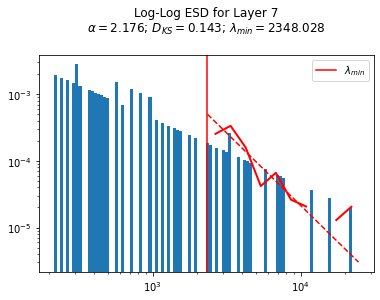

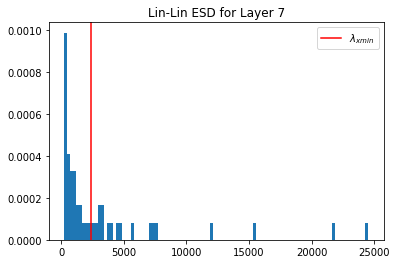

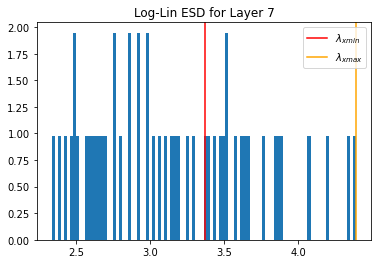

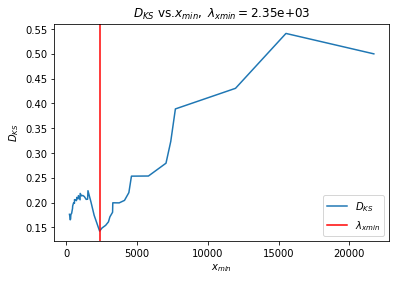

<Figure size 432x288 with 0 Axes>

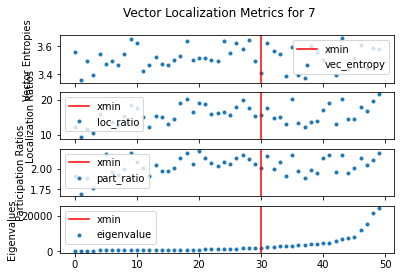

<Figure size 432x288 with 0 Axes>

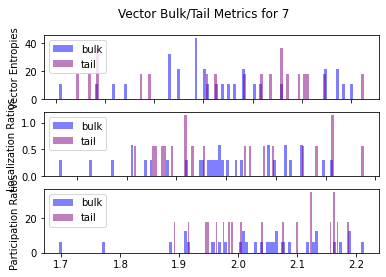

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


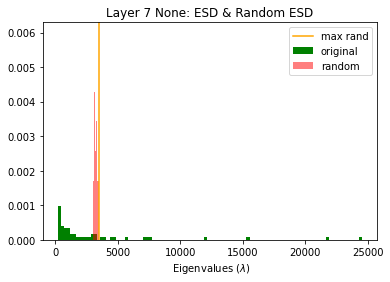

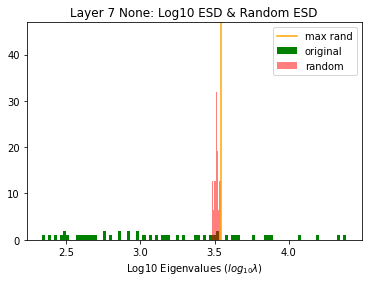

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


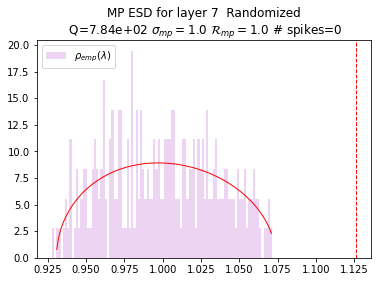

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


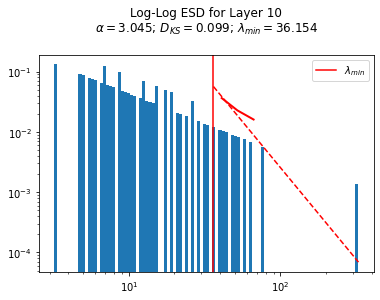

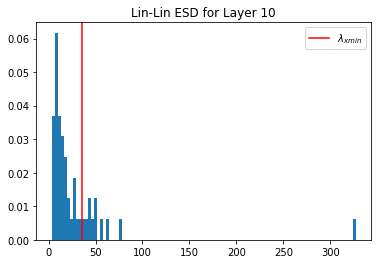

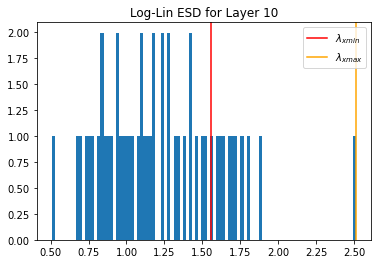

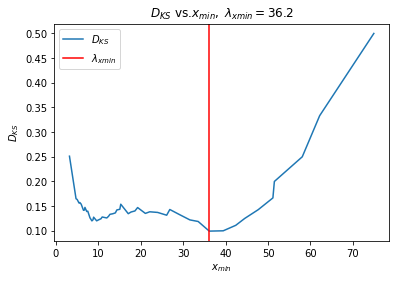

<Figure size 432x288 with 0 Axes>

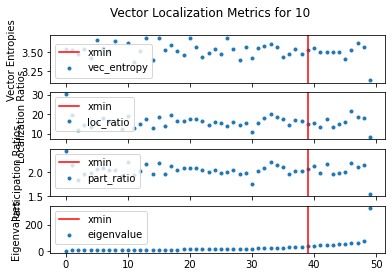

<Figure size 432x288 with 0 Axes>

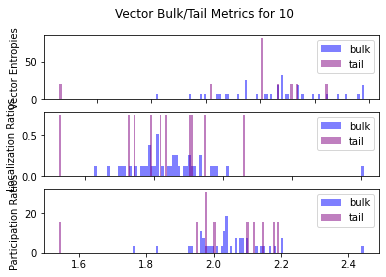

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


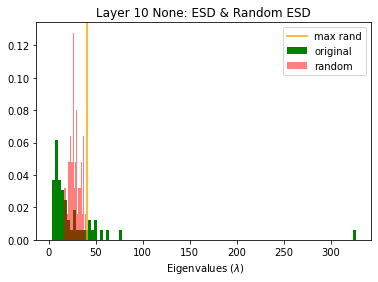

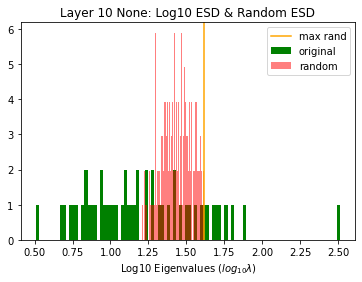

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


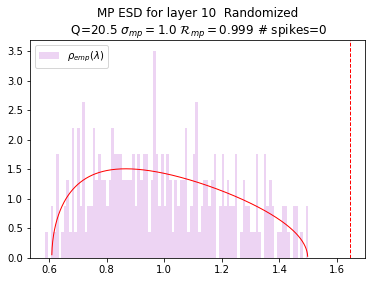

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


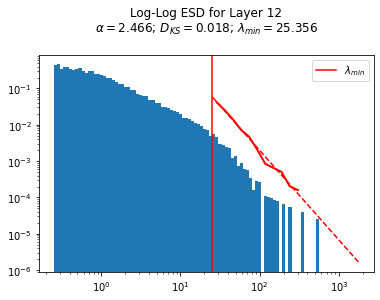

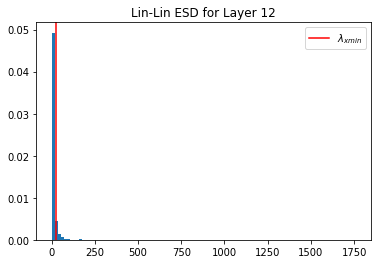

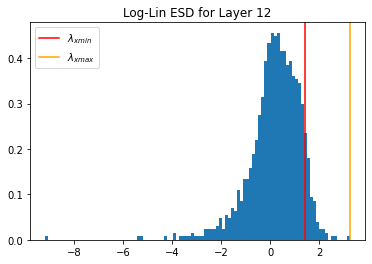

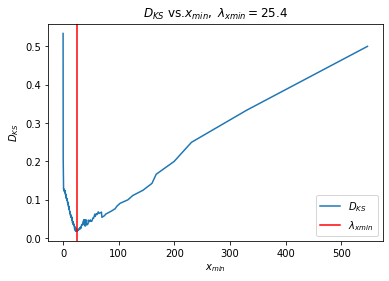

<Figure size 432x288 with 0 Axes>

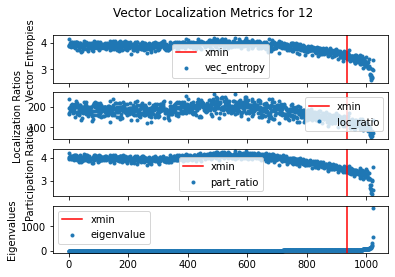

<Figure size 432x288 with 0 Axes>

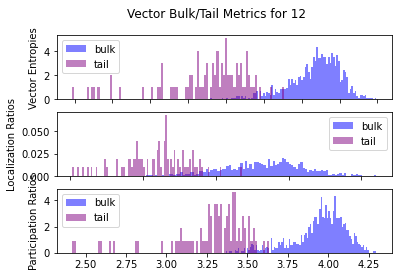

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


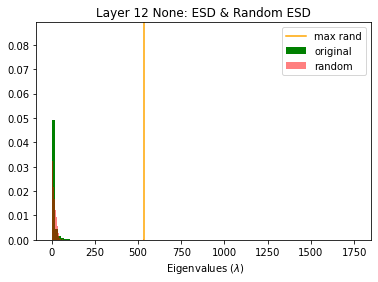

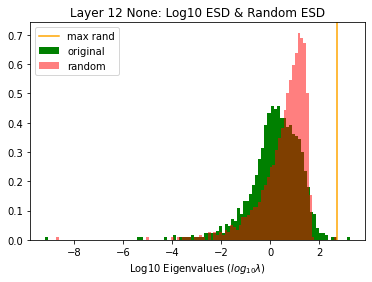

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


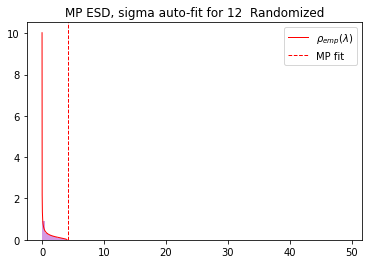

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


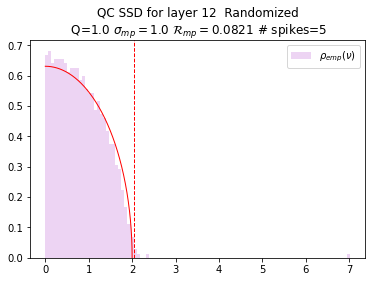

Assuming nested distributions


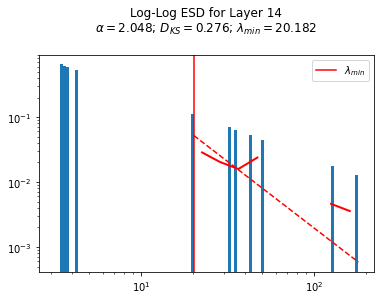

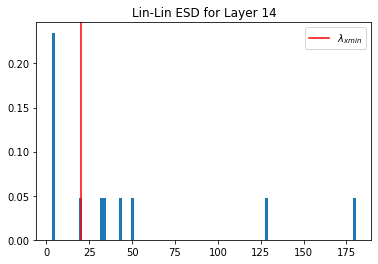

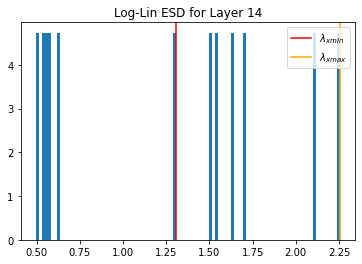

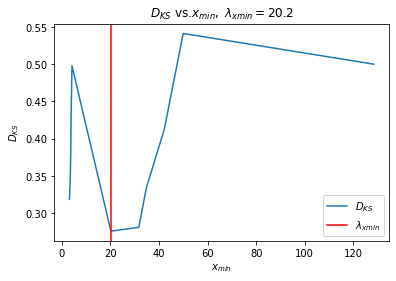

<Figure size 432x288 with 0 Axes>

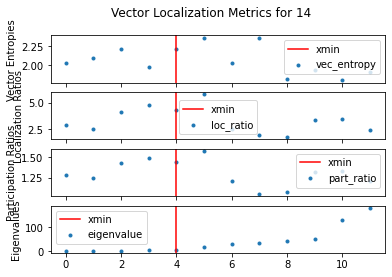

<Figure size 432x288 with 0 Axes>

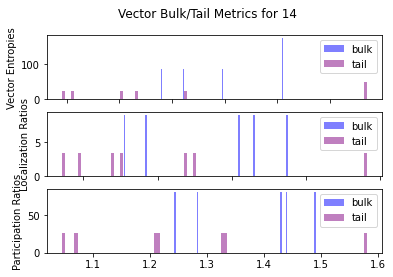

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


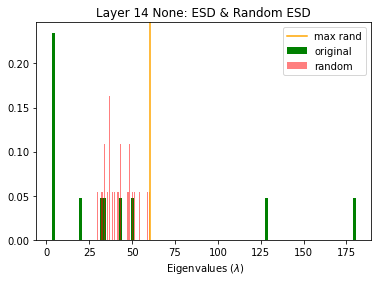

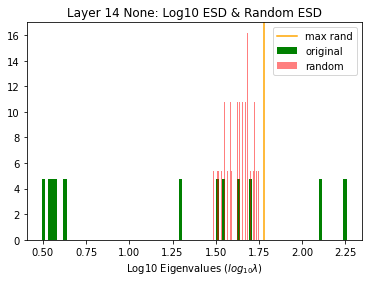

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


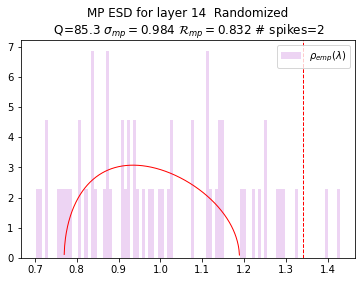

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)
INFO:weightwatcher:

python      version 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
numpy       version 1.19.2
tensforflow version 2.7.0
keras       version 2.7.0
INFO:weightwatcher:Saving all images to outputs/walker-walk-rand_inv_cutout_min10_max30
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'outputs/walker-walk-rand_norm_inv_cutout_min10_max30', 'savefig': 'outputs/walker-walk-rand_norm_inv_cutout_min10_max30', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers'

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


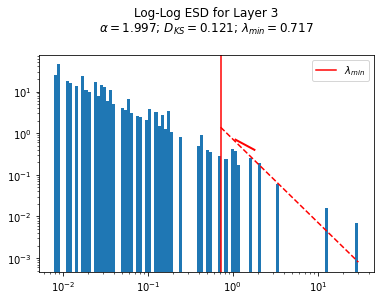

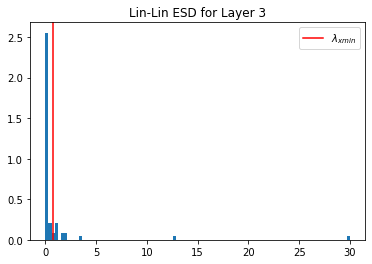

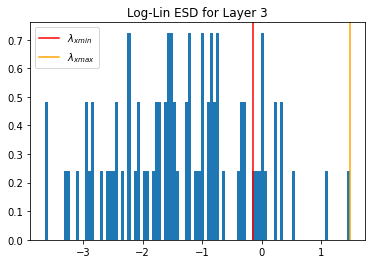

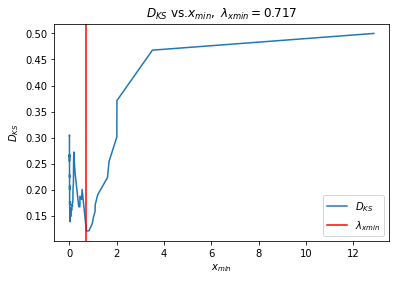

<Figure size 432x288 with 0 Axes>

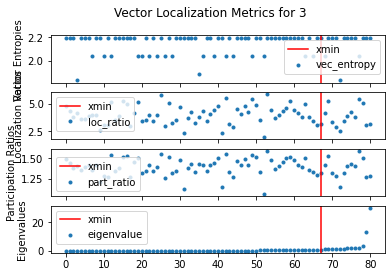

<Figure size 432x288 with 0 Axes>

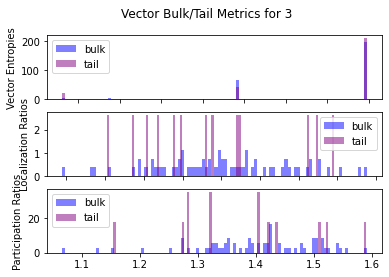

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


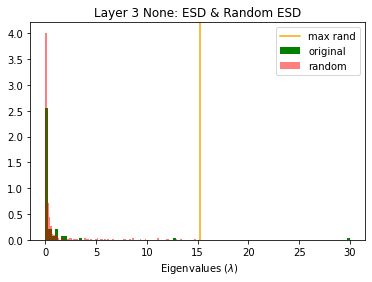

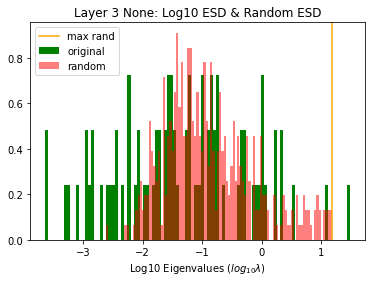

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


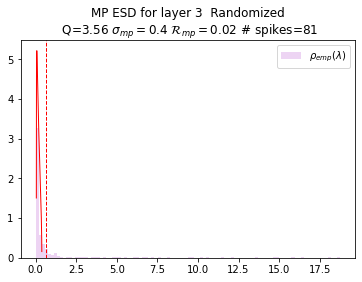

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


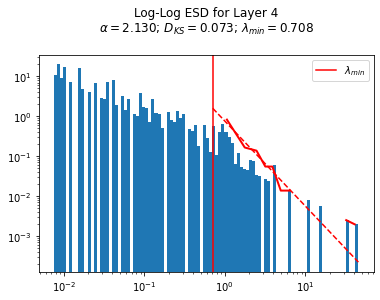

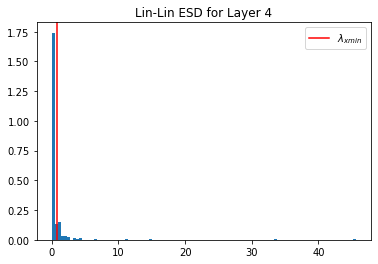

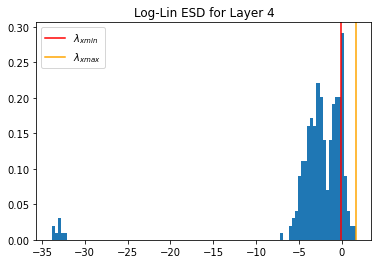

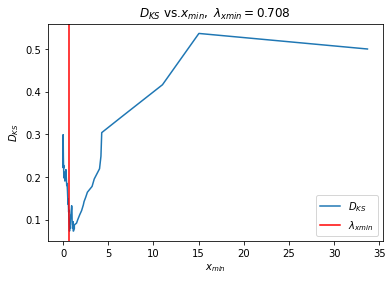

<Figure size 432x288 with 0 Axes>

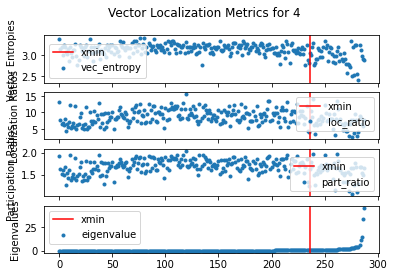

<Figure size 432x288 with 0 Axes>

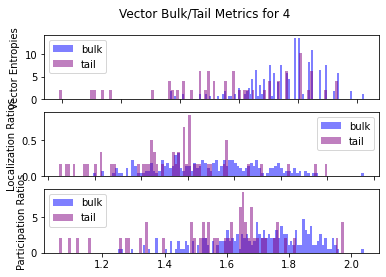

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


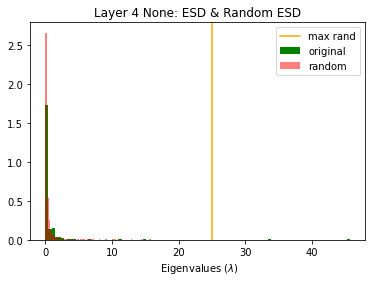

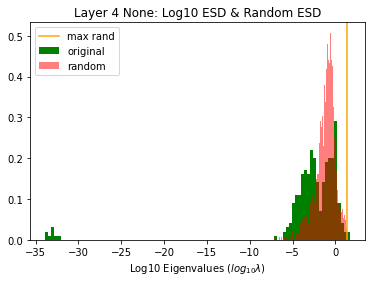

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


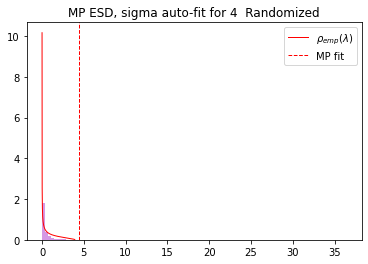

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


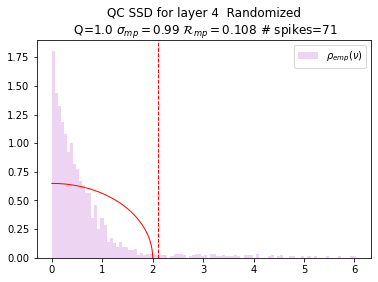

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(p * np.log(p)) / np.log(rank)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(p * np.log(p)) / np.log(rank)


Assuming nested distributions


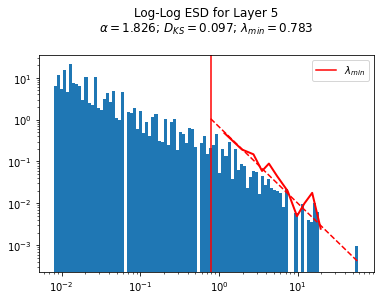

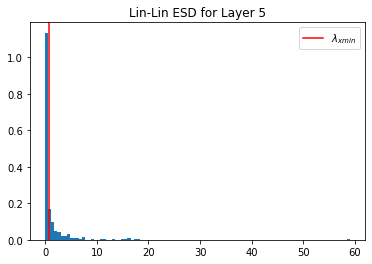

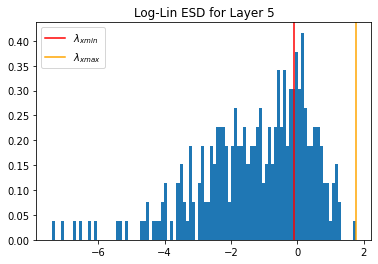

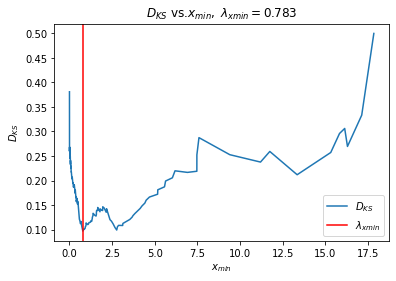

<Figure size 432x288 with 0 Axes>

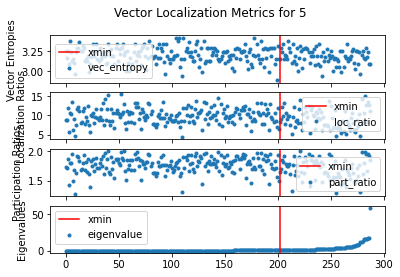

<Figure size 432x288 with 0 Axes>

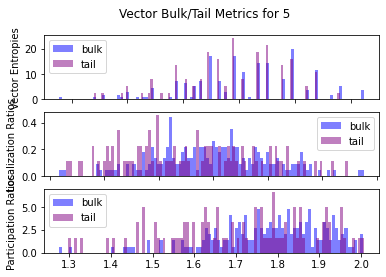

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


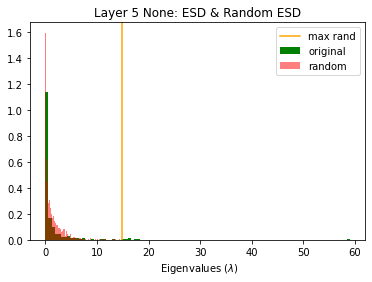

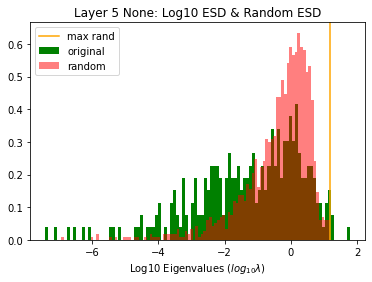

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


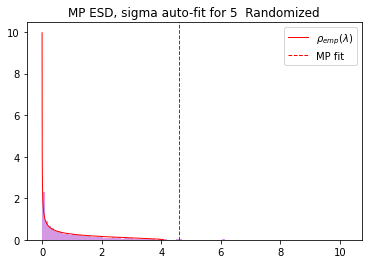

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


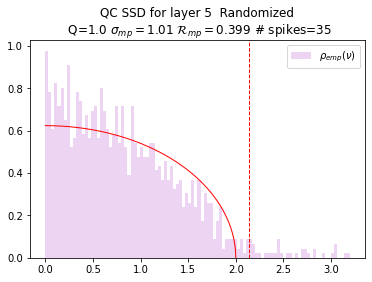

Assuming nested distributions


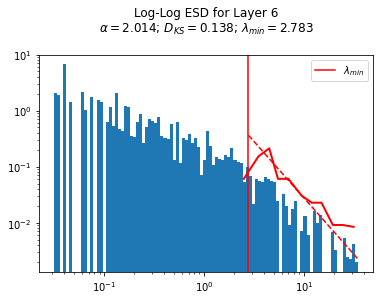

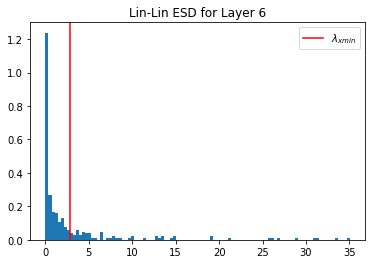

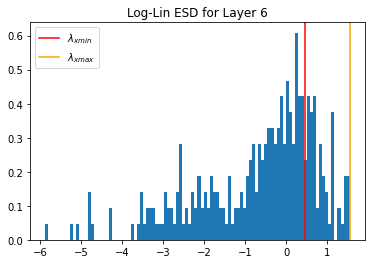

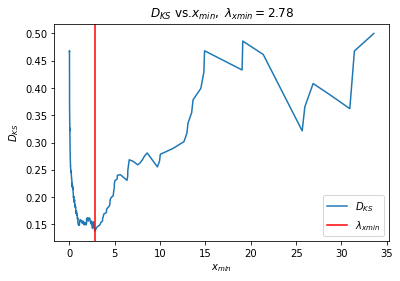

<Figure size 432x288 with 0 Axes>

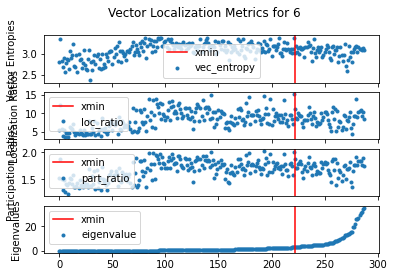

<Figure size 432x288 with 0 Axes>

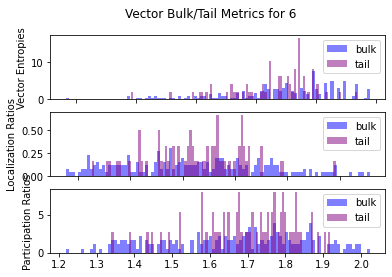

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


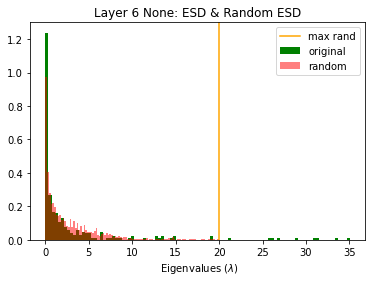

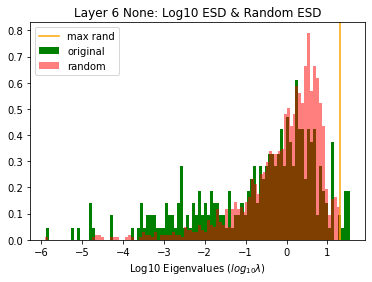

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


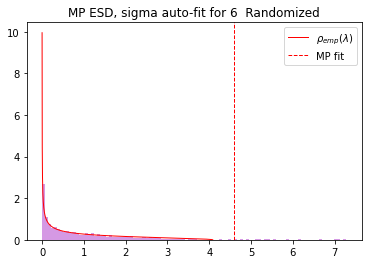

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


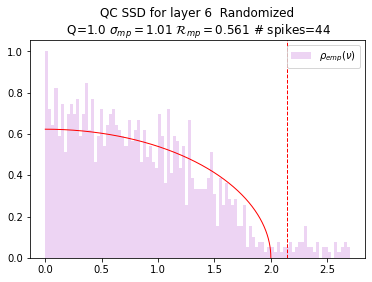

Assuming nested distributions


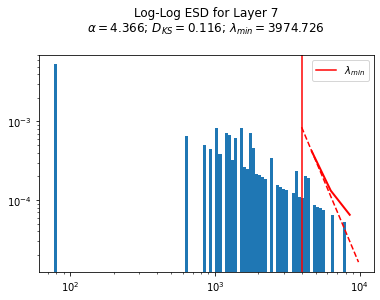

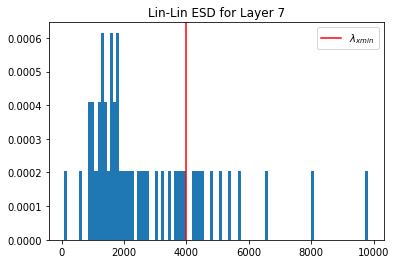

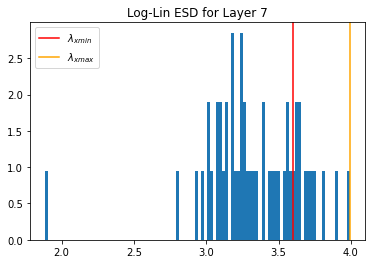

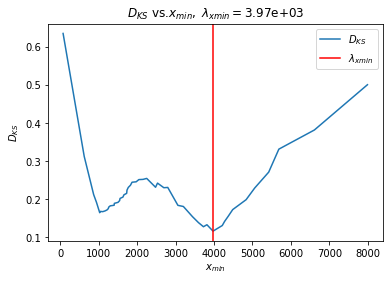

<Figure size 432x288 with 0 Axes>

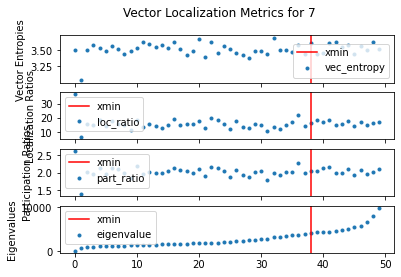

<Figure size 432x288 with 0 Axes>

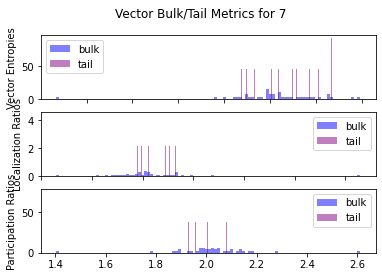

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


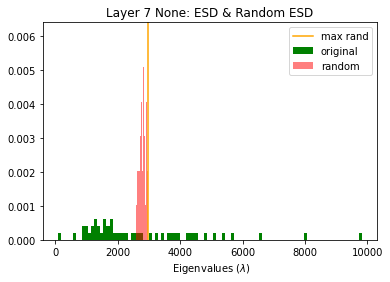

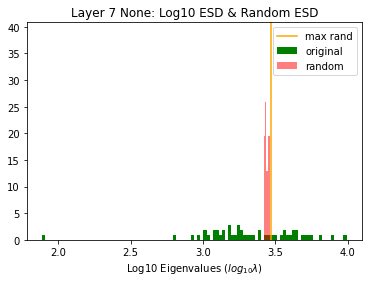

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


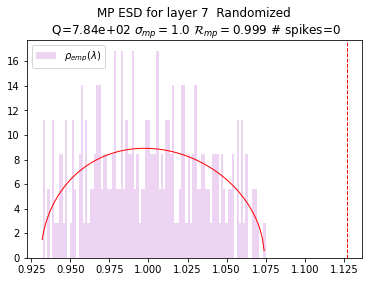

Assuming nested distributions


/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


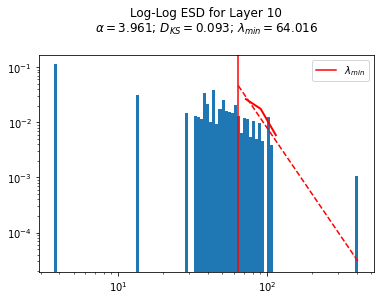

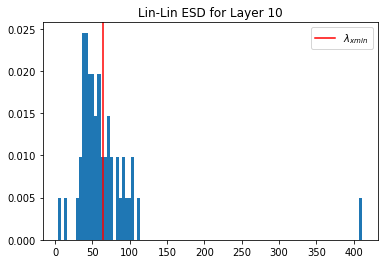

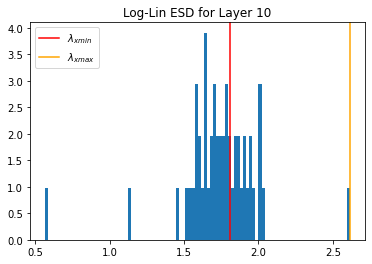

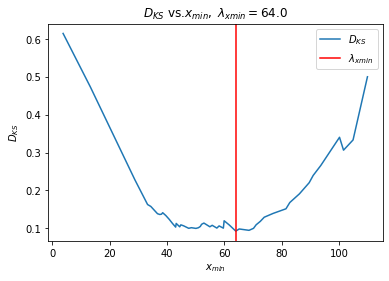

<Figure size 432x288 with 0 Axes>

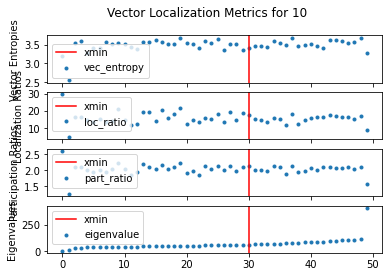

<Figure size 432x288 with 0 Axes>

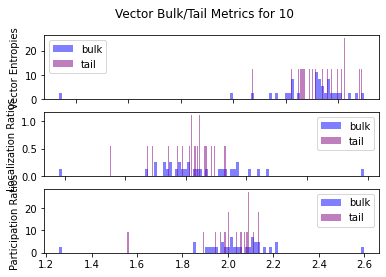

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


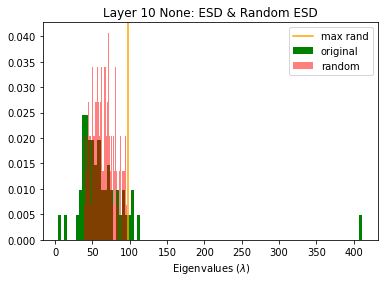

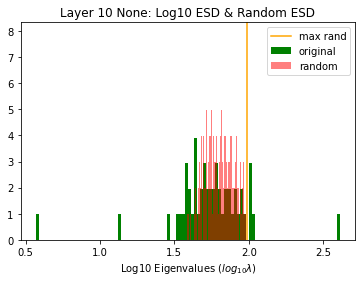

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


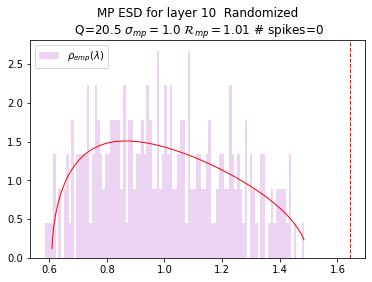

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


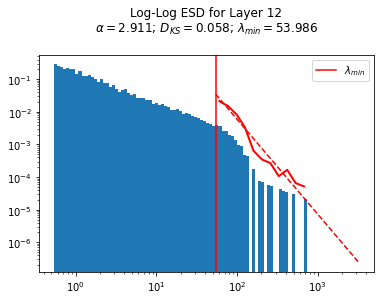

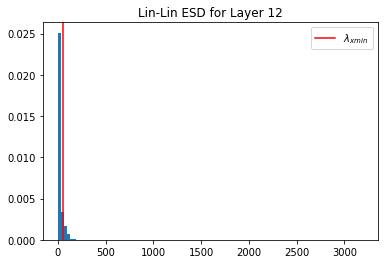

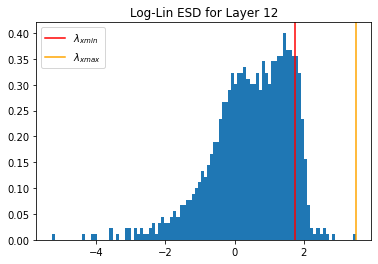

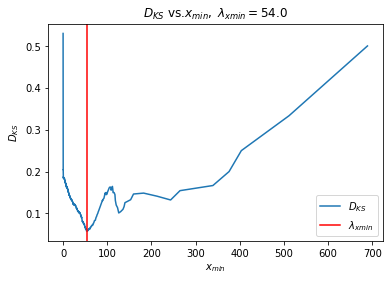

<Figure size 432x288 with 0 Axes>

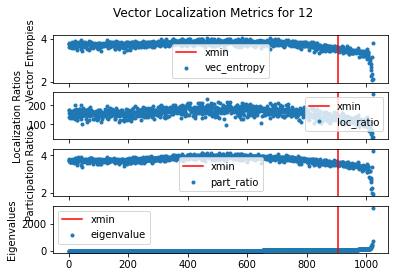

<Figure size 432x288 with 0 Axes>

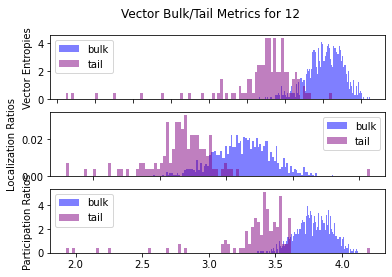

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


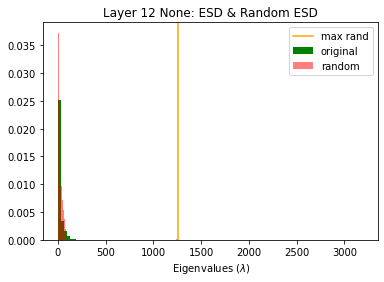

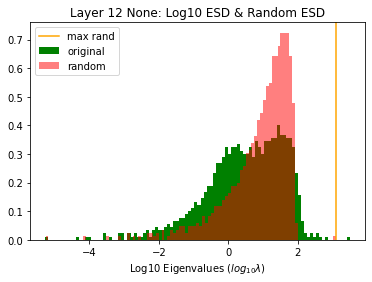

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


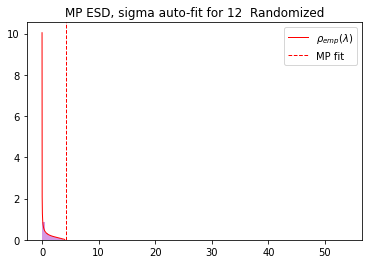

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


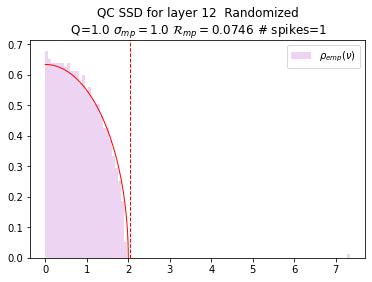

Assuming nested distributions


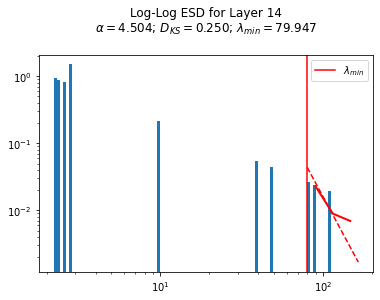

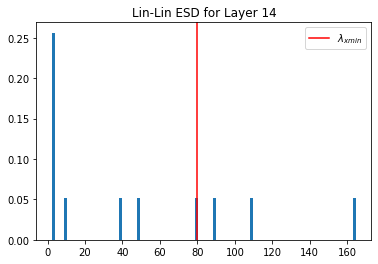

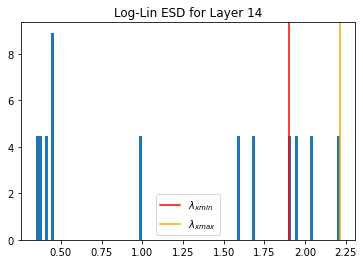

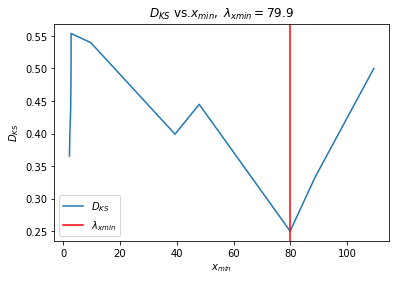

<Figure size 432x288 with 0 Axes>

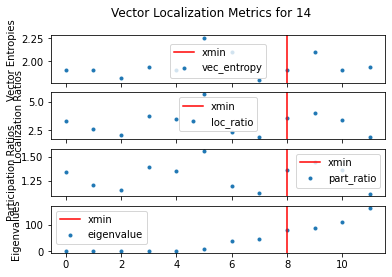

<Figure size 432x288 with 0 Axes>

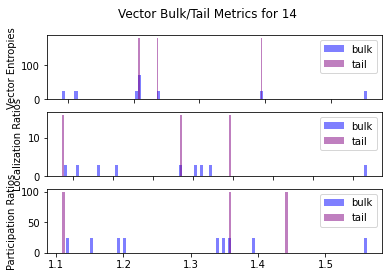

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


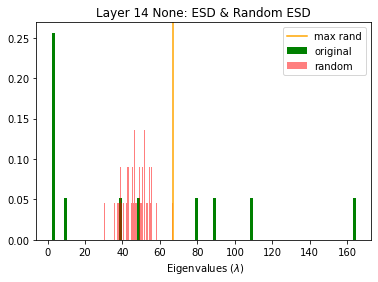

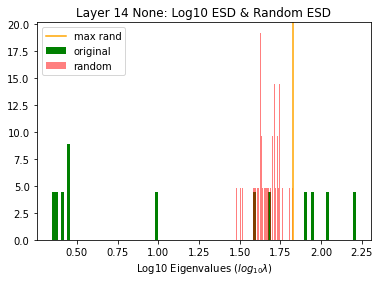

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


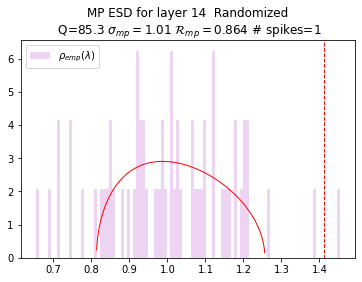

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)
INFO:weightwatcher:

python      version 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
numpy       version 1.19.2
tensforflow version 2.7.0
keras       version 2.7.0
INFO:weightwatcher:Saving all images to outputs/walker-walk-rand_norm_inv_cutout_min10_max30
INFO:weightwatcher:params {'glorot_fix': False, 'normalize': False, 'conv2d_norm': True, 'randomize': True, 'savedir': 'outputs/walker-walk-rand_static_cutout_min10_max30', 'savefig': 'outputs/walker-walk-rand_static_cutout_min10_max30', 'rescale': True, 'plot': True, 'deltaEs': False, 'intra': False, 'channels': None, 'conv2d_fft': False, 'ww2x': False, 'vectors': True, 'smooth': None, 'stacked': False, 'svd_method': 'full_svd', 'fix_fingers': False, 'min_evals': 0, 'max_evals': None, 'mp_fit': False, 'layers

Assuming nested distributions


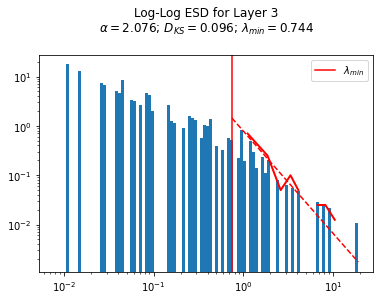

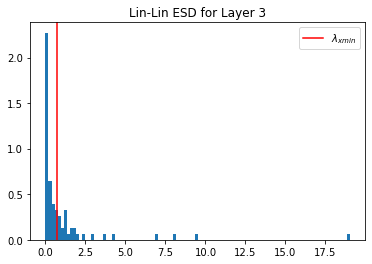

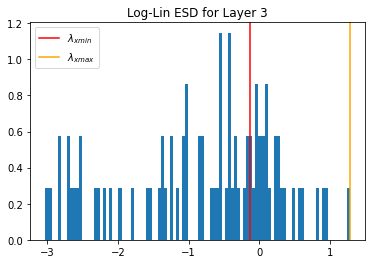

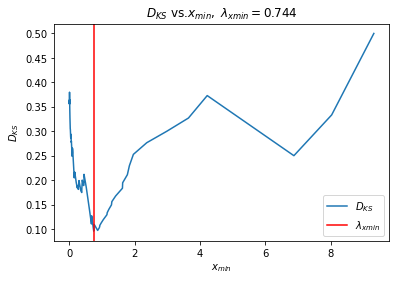

<Figure size 432x288 with 0 Axes>

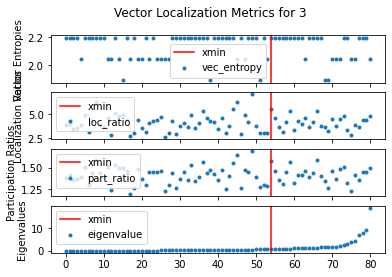

<Figure size 432x288 with 0 Axes>

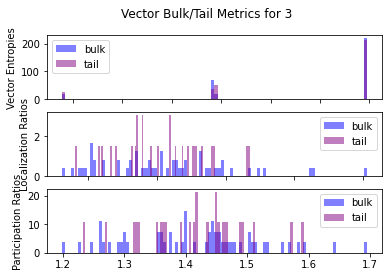

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


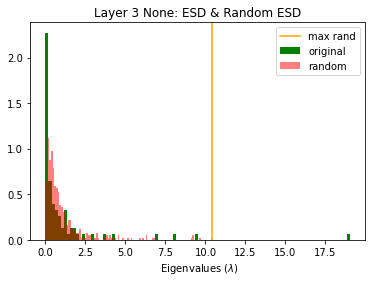

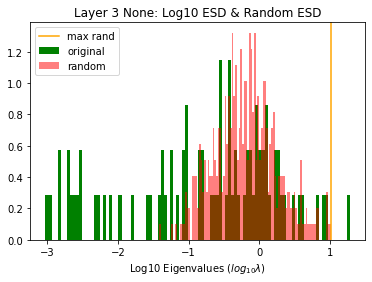

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


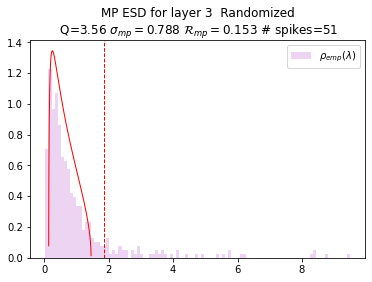

Assuming nested distributions


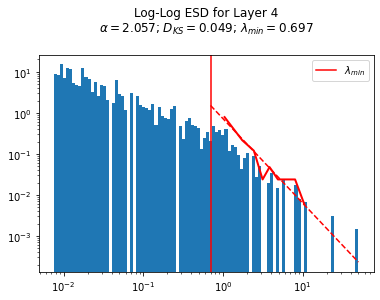

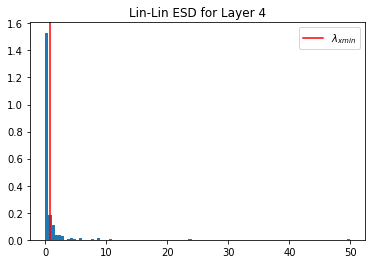

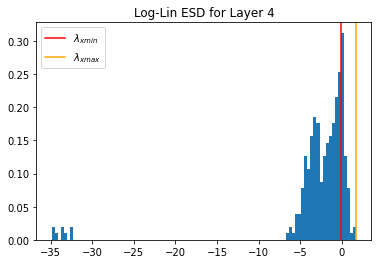

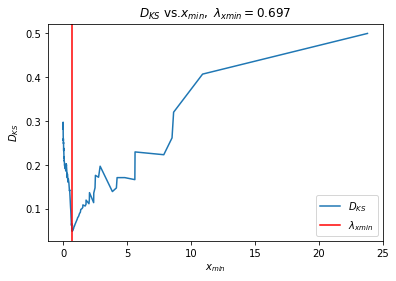

<Figure size 432x288 with 0 Axes>

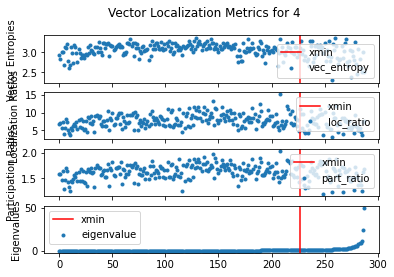

<Figure size 432x288 with 0 Axes>

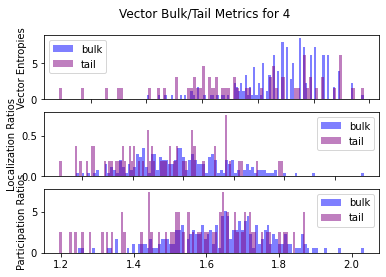

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


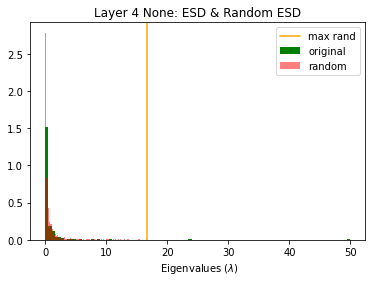

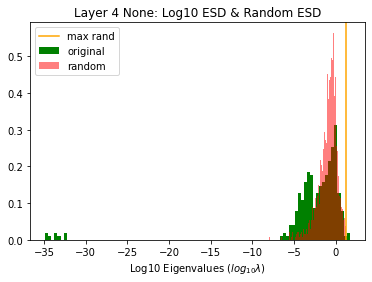

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


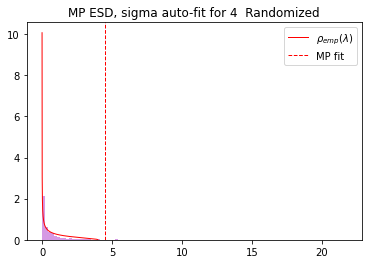

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


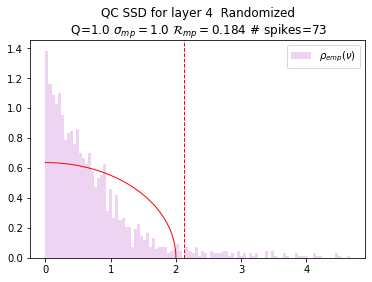

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(p * np.log(p)) / np.log(rank)
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:67: RuntimeWarning: invalid value encountered in multiply
  entropy = -np.sum(p * np.log(p)) / np.log(rank)


Assuming nested distributions


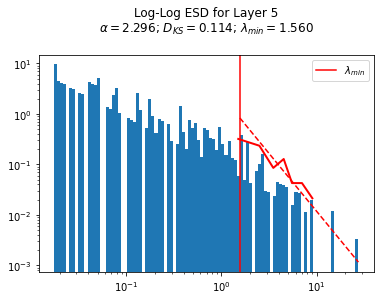

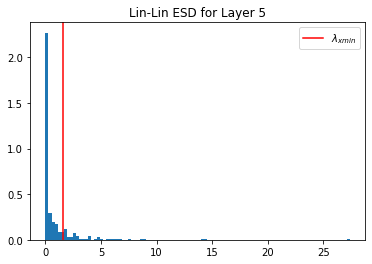

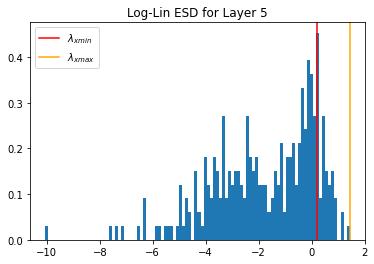

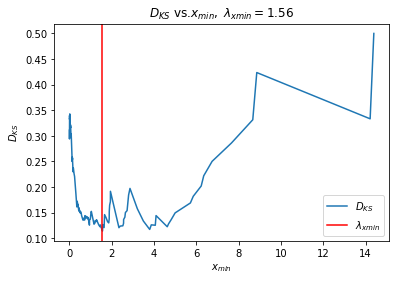

<Figure size 432x288 with 0 Axes>

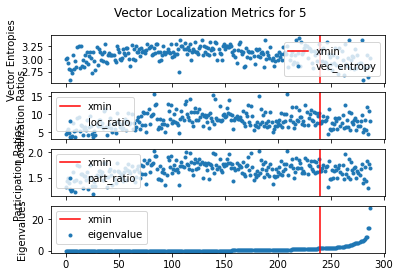

<Figure size 432x288 with 0 Axes>

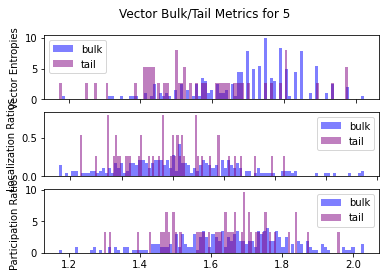

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


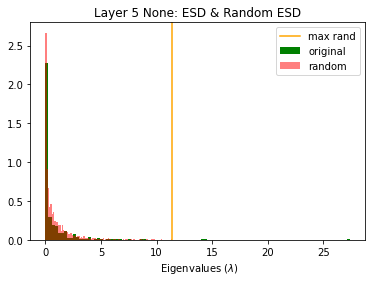

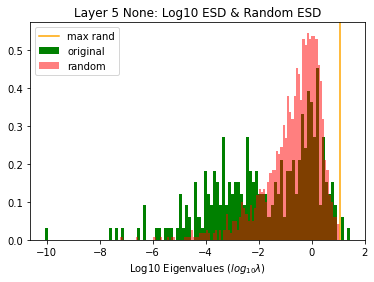

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


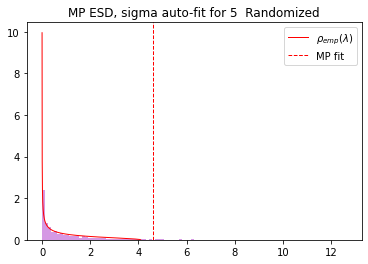

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


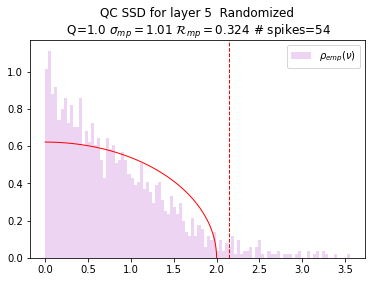

Assuming nested distributions


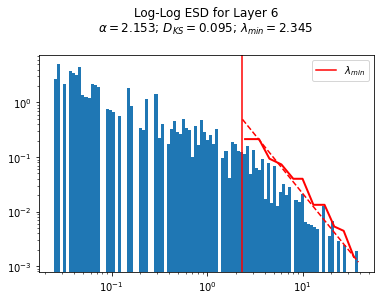

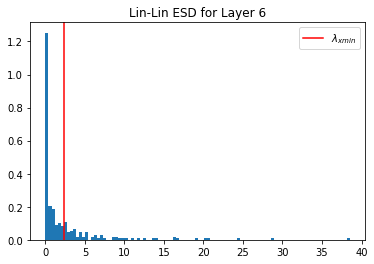

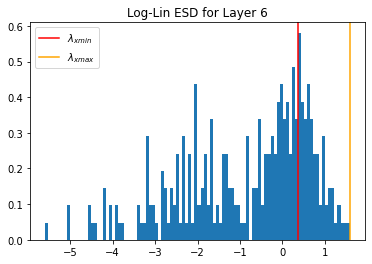

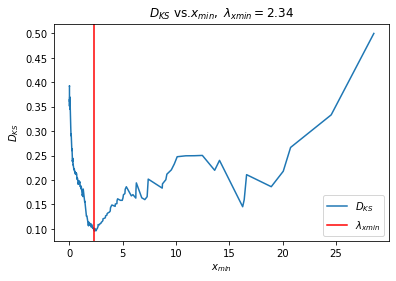

<Figure size 432x288 with 0 Axes>

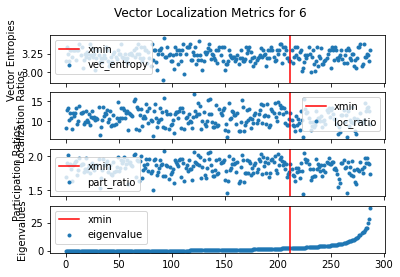

<Figure size 432x288 with 0 Axes>

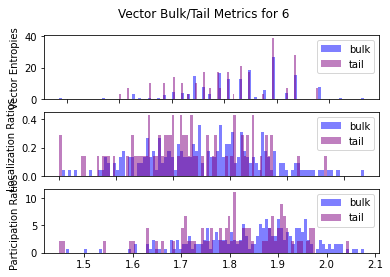

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


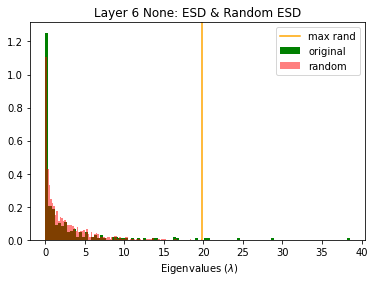

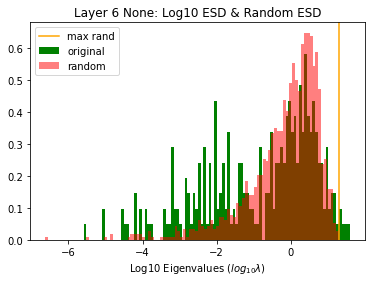

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


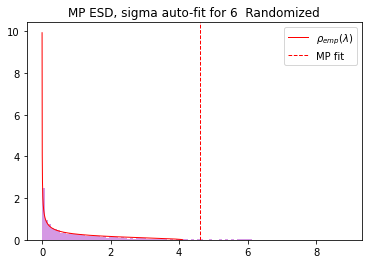

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


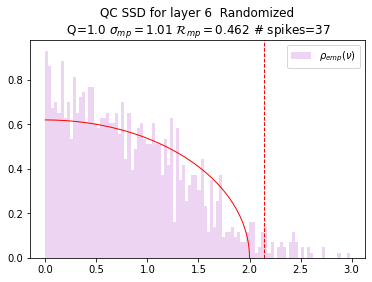

Assuming nested distributions


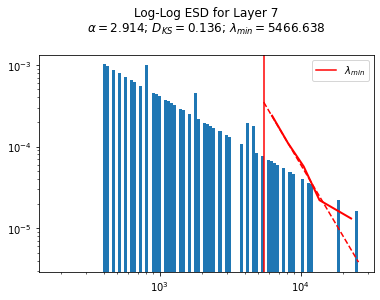

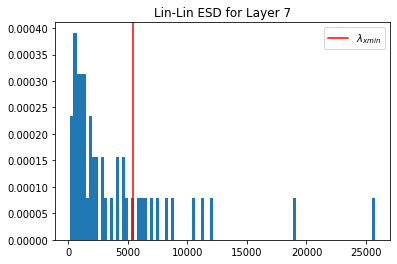

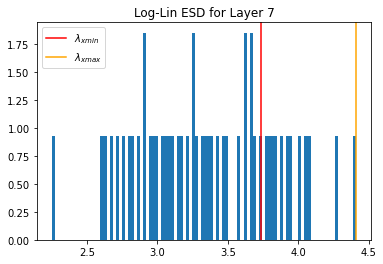

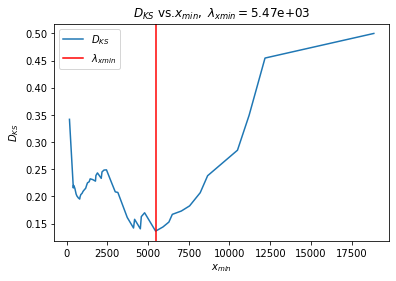

<Figure size 432x288 with 0 Axes>

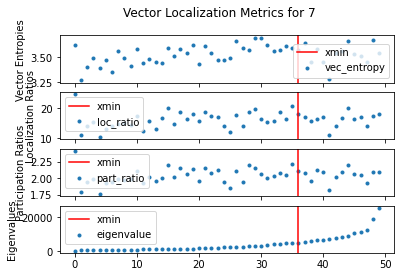

<Figure size 432x288 with 0 Axes>

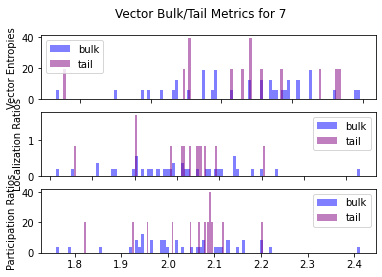

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


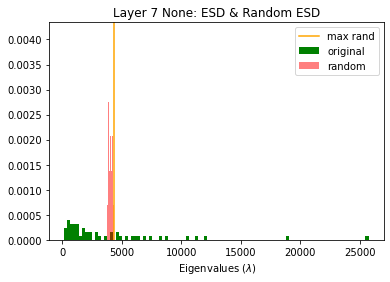

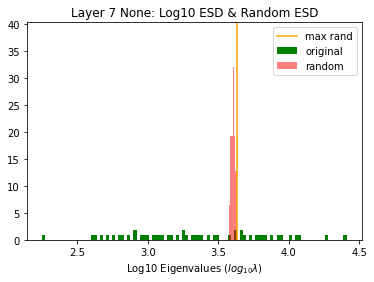

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


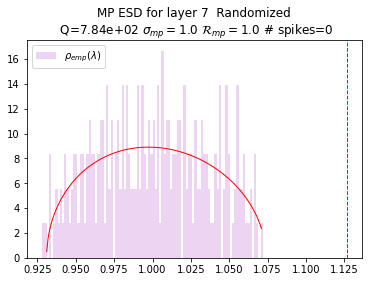

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


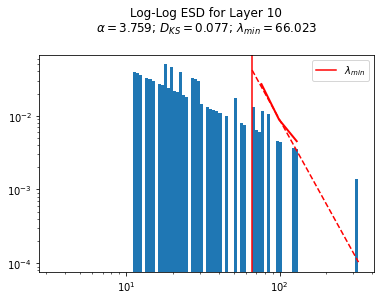

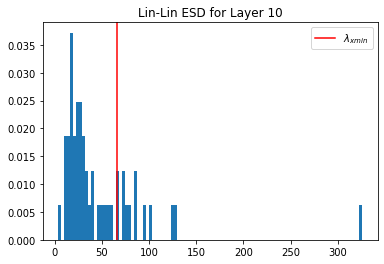

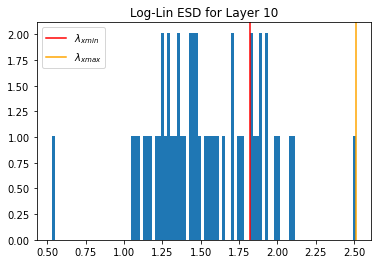

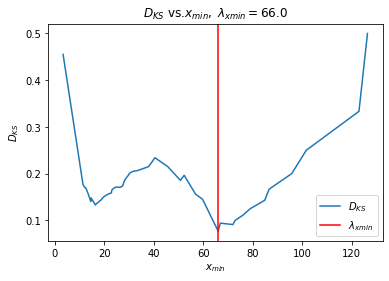

<Figure size 432x288 with 0 Axes>

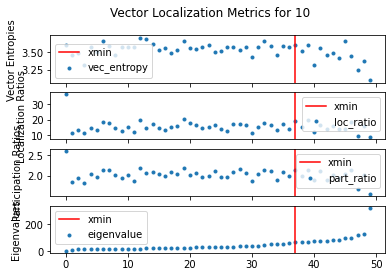

<Figure size 432x288 with 0 Axes>

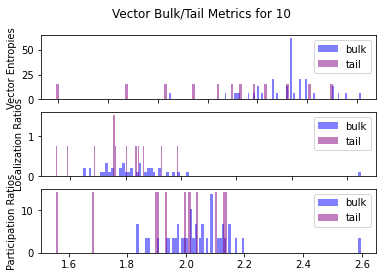

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


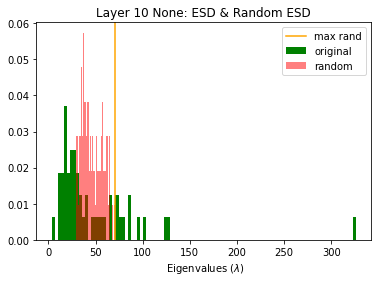

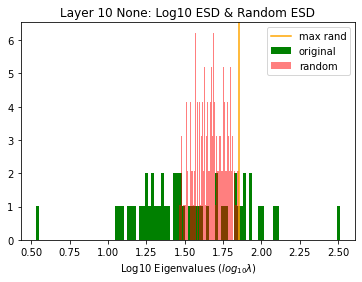

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


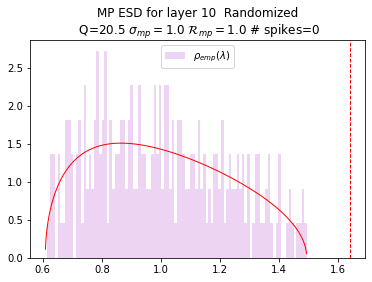

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


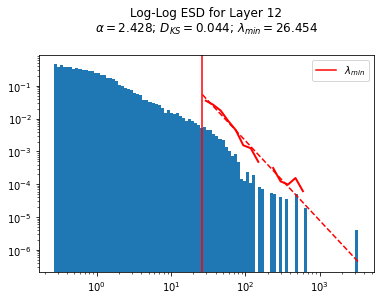

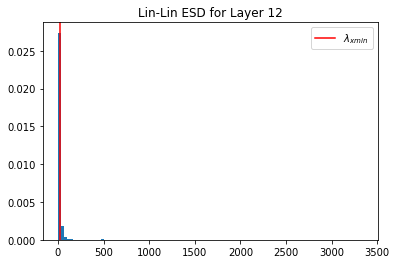

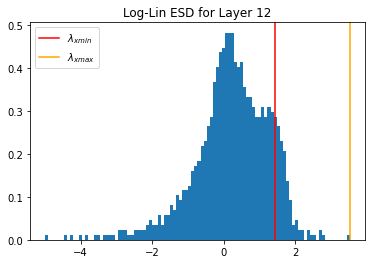

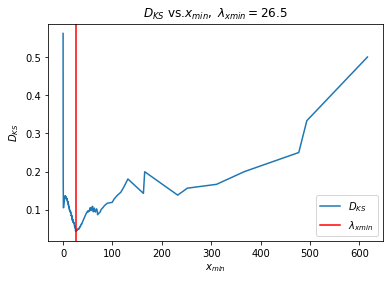

<Figure size 432x288 with 0 Axes>

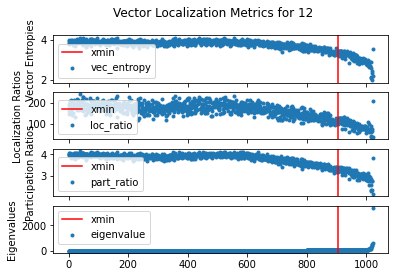

<Figure size 432x288 with 0 Axes>

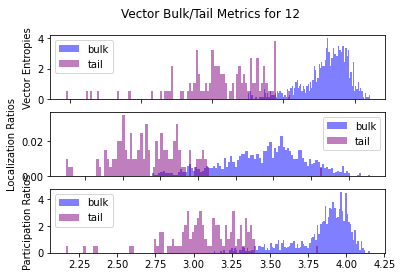

INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


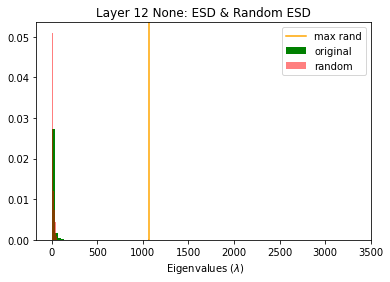

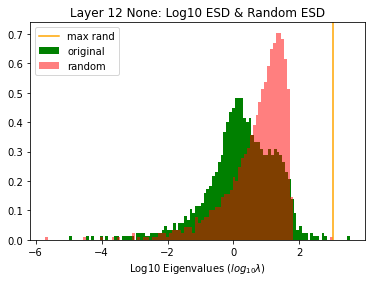

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in multiply
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


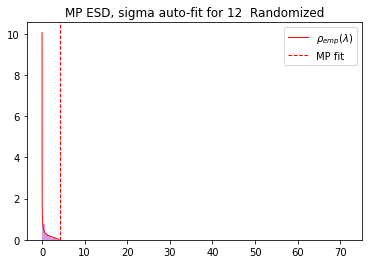

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:91: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (np.pi * sigma * sigma)) * np.sqrt(4 - x ** 2)


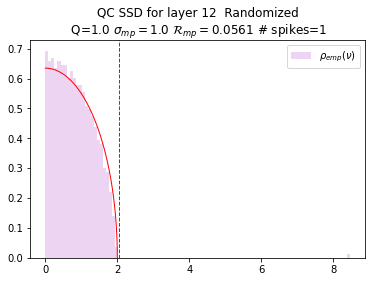

Assuming nested distributions
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in true_divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


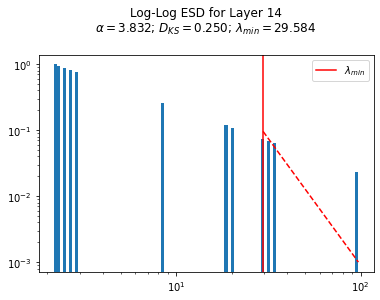

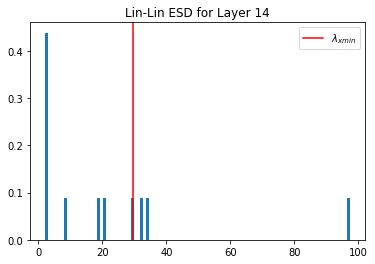

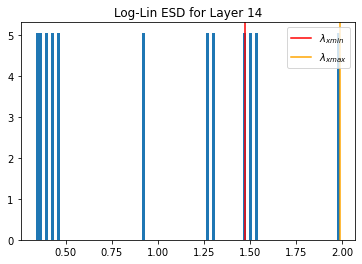

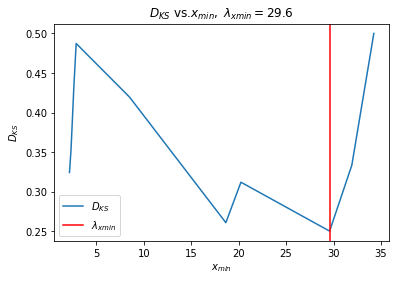

<Figure size 432x288 with 0 Axes>

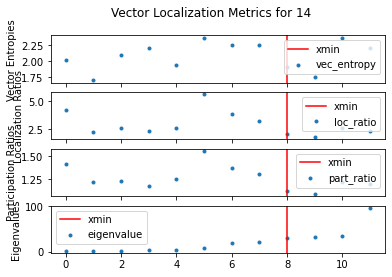

<Figure size 432x288 with 0 Axes>

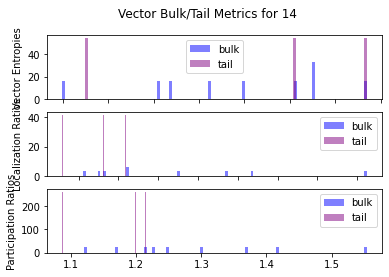

INFO:weightwatcher:generating 5 replicas for each W of the random eigenvalues
INFO:weightwatcher:generating 1 replicas for each W of the random eigenvalues


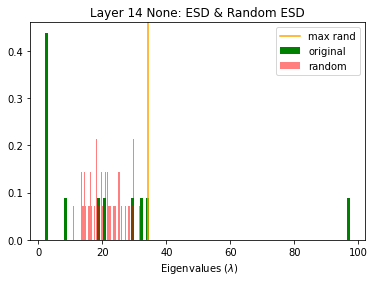

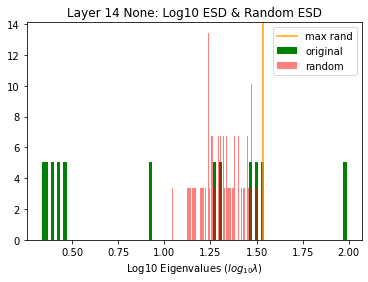

/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: divide by zero encountered in true_divide
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))
/home/aaysus/anaconda3/envs/rad/lib/python3.7/site-packages/weightwatcher/RMT_Util.py:82: RuntimeWarning: invalid value encountered in sqrt
  return x, (1 / (2 * np.pi * sigma * sigma * x * y)) * np.sqrt((b - x) * (x - a))


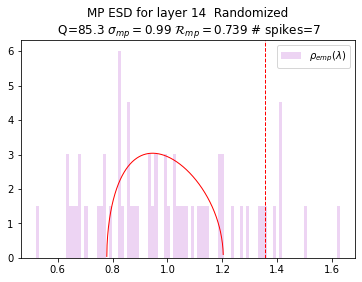

<Figure size 432x288 with 0 Axes>

In [53]:
for file_path in os.listdir('tmp'):
    plot_ww(f'tmp/{file_path}')